UNSTRUCTURED PRUNING

Setup: We will import libraries, load our pretrained model from google drive and load cifar-10 dataset

In [ ]:


import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
import copy
from google.colab import drive
from collections import OrderedDict, defaultdict
import os

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
# loading the pre-trained model obtained from MIT lab
print("LOADING PRE-TRAINED VGG-11 MODEL FROM GOOGLE DRIVE")

# mount Google Drive
print("Mounting Google Drive...")
drive.mount('/content/drive')
print(" Google Drive mounted successfully")

# Define VGG architecture for CIFAR-10
class VGG(nn.Module):
    """
    Simplified VGG architecture optimized for CIFAR-10

    Key differences from standard VGG-11:
    - Uses Global Average Pooling (GAP) instead of multiple FC layers
    - Single FC layer (512 -> 10) instead of (512 -> 4096 -> 4096 -> 10)
    - Significantly fewer parameters
    - Better suited for small 32x32 images
    """
    ARCH = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

    def __init__(self) -> None:
        super().__init__()

        layers = []
        counts = defaultdict(int)

        def add(name: str, layer: nn.Module) -> None:
            layers.append((f"{name}{counts[name]}", layer))
            counts[name] += 1

        in_channels = 3
        for x in self.ARCH:
            if x != 'M':
                # conv-bn-relu
                add("conv", nn.Conv2d(in_channels, x, 3, padding=1, bias=False))
                add("bn", nn.BatchNorm2d(x))
                add("relu", nn.ReLU(True))
                in_channels = x
            else:
                # maxpool
                add("pool", nn.MaxPool2d(2))

        self.backbone = nn.Sequential(OrderedDict(layers))
        self.classifier = nn.Linear(512, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # backbone: [N, 3, 32, 32] => [N, 512, 2, 2]
        x = self.backbone(x)

        # global Average Pooling: [N, 512, 2, 2] => [N, 512]
        x = x.mean([2, 3])

        # classifier: [N, 512] => [N, 10]
        x = self.classifier(x)
        return x

def load_model_from_drive(model_filename='vgg.cifar.pretrained.pth'):
    """
    Load pre-trained VGG model from Google Drive

    Args:
        model_filename: Name of the model file in MyDrive
    """
    # Path to model in Google Drive (adjust if in subfolder)
    model_path = f'/content/drive/MyDrive/{model_filename}'

    print(f" Found model file at: {model_path}")

    # create model
    model = VGG().to(device)

    # loading pre-trained weights
    print("Loading pre-trained weights...")
    print("Inspecting checkpoint structure...")

    try:
        checkpoint = torch.load(model_path, map_location=device)
        # debug: Print checkpoint structure
        print(f"\nCheckpoint type: {type(checkpoint)}")
        if isinstance(checkpoint, dict):
            print(f"Checkpoint keys: {checkpoint.keys()}")

            # try different keys
            if 'state_dict' in checkpoint:
                print("Found 'state_dict' key")
                state_dict = checkpoint['state_dict']
            elif 'model' in checkpoint:
                print("Found 'model' key")
                state_dict = checkpoint['model']
            elif 'net' in checkpoint:
                print("Found 'net' key")
                state_dict = checkpoint['net']
            else:
                print("Using checkpoint as state_dict directly")
                state_dict = checkpoint
        else:
            print("Checkpoint is direct state_dict")
            state_dict = checkpoint

        # debug: Print first few keys from state_dict
        if isinstance(state_dict, dict):
            print(f"\nState dict keys (first 5): {list(state_dict.keys())[:5]}")
            print(f"Total keys in state_dict: {len(state_dict)}")

            # check if keys match our model
            model_keys = set(model.state_dict().keys())
            checkpoint_keys = set(state_dict.keys())

            print(f"\nModel keys (first 5): {list(model_keys)[:5]}")
            print(f"Total keys in model: {len(model_keys)}")

            # check for key mismatches
            if model_keys != checkpoint_keys:
                print("\n Key mismatch detected!")
                missing = model_keys - checkpoint_keys
                unexpected = checkpoint_keys - model_keys

                if missing:
                    print(f"Missing keys in checkpoint: {list(missing)[:5]}")
                if unexpected:
                    print(f"Unexpected keys in checkpoint: {list(unexpected)[:5]}")

                # Try to fix common key prefix issues
                if any(k.startswith('module.') for k in checkpoint_keys):
                    print("\nDetected 'module.' prefix - removing it...")
                    state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}

                # Try to map keys if structure is similar
                print("\nAttempting to load with strict=False...")
                result = model.load_state_dict(state_dict, strict=False)
                print(f"Missing keys: {len(result.missing_keys)}")
                print(f"Unexpected keys: {len(result.unexpected_keys)}")
            else:
                print("\n Keys match perfectly!")
                model.load_state_dict(state_dict)
        else:
            print(" State dict is not a dictionary!")
            return None

        print("\n Pre-trained weights loaded!")

        # Verify the model is actually loaded by checking a random weight
        first_param = next(model.parameters())
        if torch.all(first_param == 0):
            print("  WARNING: Weights appear to be all zeros!")
        else:
            print(f"Weight check passed (sample value: {first_param.flatten()[0].item():.6f})")

    except Exception as e:
        print(f"\n Failed to load weights: {e}")
        import traceback
        traceback.print_exc()
        return None

    return model

# Load the model
model = load_model_from_drive('vgg.cifar.pretrained.pth')

print("\n VGG-11 model ready")
print(f" Model is on: {next(model.parameters()).device}")

LOADING PRE-TRAINED VGG-11 MODEL FROM GOOGLE DRIVE
Mounting Google Drive...
Mounted at /content/drive
 Google Drive mounted successfully
 Found model file at: /content/drive/MyDrive/vgg.cifar.pretrained.pth
Loading pre-trained weights...
Inspecting checkpoint structure...

Checkpoint type: <class 'dict'>
Checkpoint keys: dict_keys(['state_dict'])
Found 'state_dict' key

State dict keys (first 5): ['backbone.conv0.weight', 'backbone.bn0.weight', 'backbone.bn0.bias', 'backbone.bn0.running_mean', 'backbone.bn0.running_var']
Total keys in state_dict: 50

Model keys (first 5): ['classifier.bias', 'backbone.bn4.running_var', 'backbone.bn2.bias', 'backbone.conv6.weight', 'backbone.bn6.weight']
Total keys in model: 50

 Keys match perfectly!

 Pre-trained weights loaded!
Weight check passed (sample value: 0.110260)

 VGG-11 model ready
 Model is on: cuda:0


 DATASET PREPARATION & BASE MODEL EVALUATION


100%|██████████| 170M/170M [00:40<00:00, 4.16MB/s]


 CIFAR-10 dataset loaded (using [0,1] normalization)

Visualizing dataset samples...


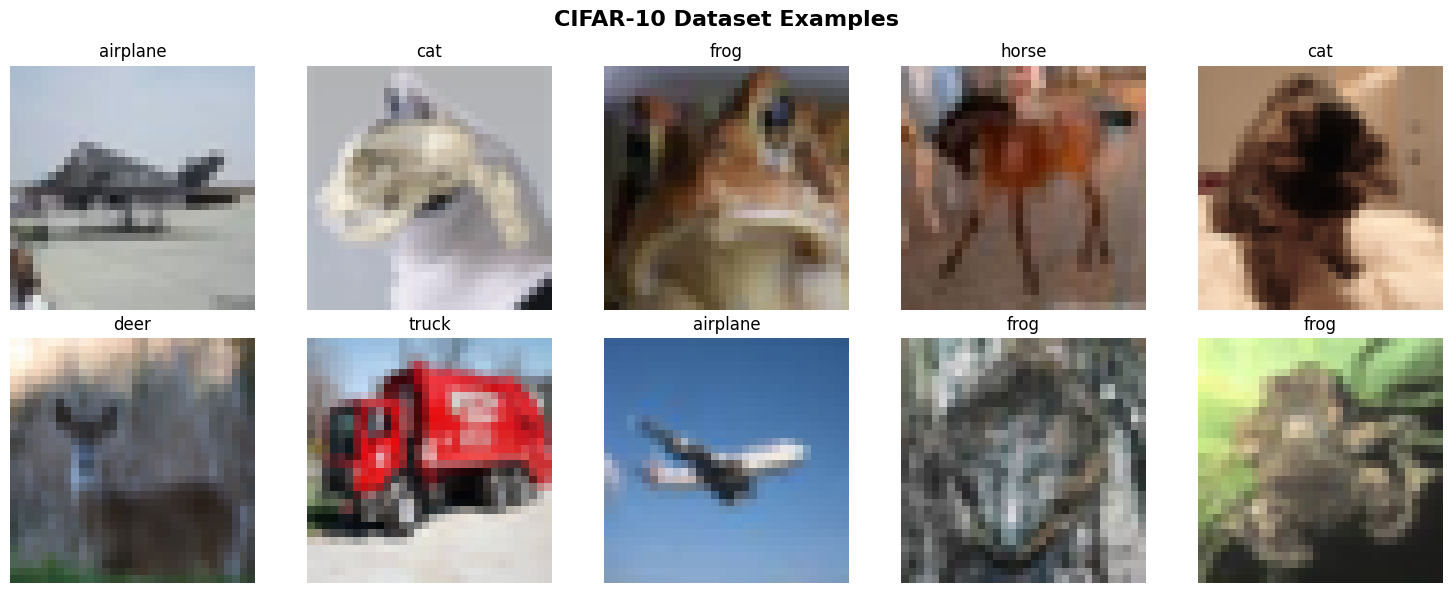


Calculating base model metrics...
 Total Parameters: 9,228,362
 Trainable Parameters: 9,228,362
 Model Size: 35.22 MB

Evaluating base model accuracy...


Evaluating: 100%|██████████| 100/100 [00:03<00:00, 32.30it/s]


 Base Model Accuracy: 92.95%
WEIGHT DISTRIBUTION VISUALIZATION (BEFORE PRUNING)

Plotting weight distributions (before pruning)...
 Saved as weights_before_pruning.png


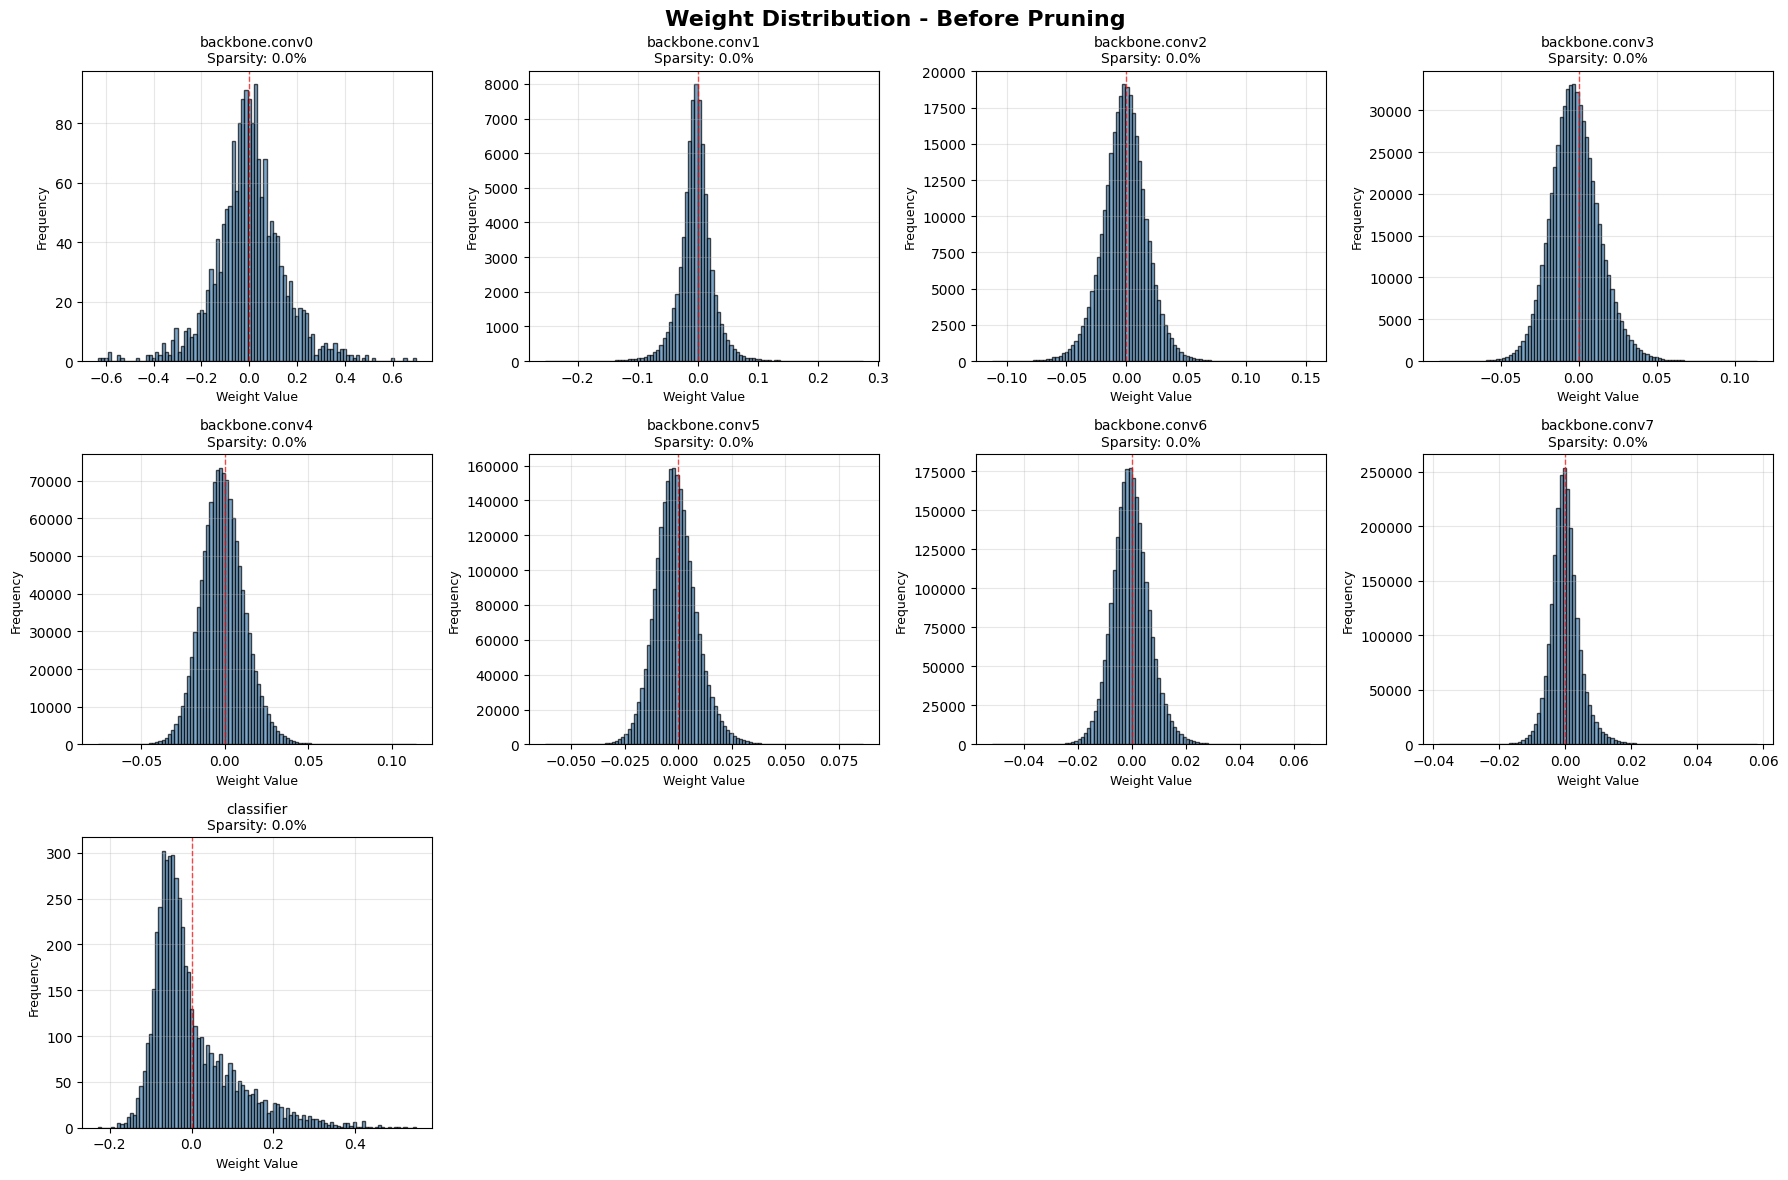

In [3]:
# dataset & Base Model Evaluation
print(" DATASET PREPARATION & BASE MODEL EVALUATION")

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

print(" CIFAR-10 dataset loaded (using [0,1] normalization)")

# Visualize dataset examples
def visualize_dataset(dataset, n_samples=10):
    """Visualize random samples from CIFAR-10"""
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()

    indices = np.random.choice(len(dataset), n_samples, replace=False)

    for idx, ax in zip(indices, axes):
        img, label = dataset[idx]
        img = img.permute(1, 2, 0).numpy()
        ax.imshow(img)
        ax.set_title(f'{classes[label]}', fontsize=12)
        ax.axis('off')

    plt.suptitle('CIFAR-10 Dataset Examples', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("\nVisualizing dataset samples...")
visualize_dataset(testset)

# model size
def calculate_model_size(model):
    """Calculate total parameters and model size"""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    # model size in MB
    param_size = sum(p.numel() * p.element_size() for p in model.parameters())
    buffer_size = sum(b.numel() * b.element_size() for b in model.buffers())
    size_mb = (param_size + buffer_size) / (1024 ** 2)

    return total_params, trainable_params, size_mb

def evaluate_model(model, testloader):
    """Evaluate model accuracy"""
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    return accuracy

print("\nCalculating base model metrics...")
total_params, trainable_params, size_mb = calculate_model_size(model)
print(f" Total Parameters: {total_params:,}")
print(f" Trainable Parameters: {trainable_params:,}")
print(f" Model Size: {size_mb:.2f} MB")

print("\nEvaluating base model accuracy...")
base_accuracy = evaluate_model(model, testloader)
print(f" Base Model Accuracy: {base_accuracy:.2f}%")

#visualize weight distribution of base model
print("WEIGHT DISTRIBUTION VISUALIZATION (BEFORE PRUNING)")

def get_prunable_layers(model):
    """get all Conv2d and Linear layers for pruning"""
    prunable_layers = []
    layer_names = []

    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            prunable_layers.append(module)
            layer_names.append(name)

    return prunable_layers, layer_names

def plot_weight_distribution(model, title="Weight Distribution", save_name=None):
    """Plot weight distribution for all prunable layers"""
    prunable_layers, layer_names = get_prunable_layers(model)

    n_layers = len(prunable_layers)
    n_cols = 4
    n_rows = (n_layers + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4*n_rows))
    axes = axes.flatten() if n_layers > 1 else [axes]

    for idx, (layer, name) in enumerate(zip(prunable_layers, layer_names)):
        weights = layer.weight.data.cpu().numpy().flatten()

        # Count zeros
        non_zero_weights = weights[weights != 0]
        zero_count = len(weights) - len(non_zero_weights)
        sparsity = 100 * zero_count / len(weights)

        ax = axes[idx]
        ax.hist(weights, bins=100, alpha=0.7, edgecolor='black', color='steelblue')
        ax.set_title(f'{name}\nSparsity: {sparsity:.1f}%', fontsize=10)
        ax.set_xlabel('Weight Value', fontsize=9)
        ax.set_ylabel('Frequency', fontsize=9)
        ax.grid(True, alpha=0.3)
        ax.axvline(x=0, color='red', linestyle='--', linewidth=1, alpha=0.7)

    # Hide unused subplots
    for idx in range(n_layers, len(axes)):
        axes[idx].axis('off')

    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()

    if save_name:
        plt.savefig(save_name, dpi=150, bbox_inches='tight')
        print(f" Saved as {save_name}")

    plt.show()

print("\nPlotting weight distributions (before pruning)...")
plot_weight_distribution(model, "Weight Distribution - Before Pruning",
                        "weights_before_pruning.png")

In [49]:
# magnitude-based unstructured pruning function

def magnitude_prune_layer(layer, sparsity):
    """
    Prune a single layer based on L2-norm magnitude
    Sets weights with smallest magnitudes to zero

    Args:
        layer: Conv2d or Linear layer
        sparsity: fraction of weights to prune (0.0 to 1.0)
    """
    if not isinstance(layer, (nn.Conv2d, nn.Linear)):
        return

    weight = layer.weight.data
    weight_abs = torch.abs(weight)

    # we will calculate threshold based on sparsity
    threshold = torch.quantile(weight_abs.flatten(), sparsity)

    # creating mask: 0 for pruned weights, 1 for kept weights
    mask = (weight_abs > threshold).float()

    # applying mask
    layer.weight.data *= mask

    # store mask for future use
    layer.register_buffer('weight_mask', mask)

    return mask

def prune_model(model, sparsity_dict):
    """
    Prune entire model with layer-specific sparsity ratios

    Args:
        model: PyTorch model
        sparsity_dict: {layer_name: sparsity_ratio}
    """
    prunable_layers, layer_names = get_prunable_layers(model)

    for layer, name in zip(prunable_layers, layer_names):
        if name in sparsity_dict:
            magnitude_prune_layer(layer, sparsity_dict[name])

    return model

def calculate_sparsity(model):
    """Calculate overall sparsity of the model"""
    total_params = 0
    zero_params = 0

    for module in model.modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            params = module.weight.data
            total_params += params.numel()
            zero_params += (params == 0).sum().item()

    if total_params == 0:
        return 0.0
    return 100. * zero_params / total_params

SENSITIVITY ANALYSIS
Running sensitivity analysis (this will take some time)...

Starting sensitivity analysis...
Testing sparsity levels: ['0%', '20%', '40%', '60%', '80%', '90%']



Baseline Model Accuracy: 92.95%

[1/9] Analyzing layer: backbone.conv0


  Sparsity:    0% -> Accuracy: 92.95% (Drop:  0.00%)


  Sparsity:   20% -> Accuracy: 92.96% (Drop: -0.01%)


  Sparsity:   40% -> Accuracy: 92.42% (Drop:  0.53%)


  Sparsity:   60% -> Accuracy: 87.55% (Drop:  5.40%)


  Sparsity:   80% -> Accuracy: 69.41% (Drop: 23.54%)


  Sparsity:   90% -> Accuracy: 31.81% (Drop: 61.14%)

[2/9] Analyzing layer: backbone.conv1


  Sparsity:    0% -> Accuracy: 92.95% (Drop:  0.00%)


  Sparsity:   20% -> Accuracy: 92.91% (Drop:  0.04%)


  Sparsity:   40% -> Accuracy: 92.93% (Drop:  0.02%)


  Sparsity:   60% -> Accuracy: 92.71% (Drop:  0.24%)


  Sparsity:   80% -> Accuracy: 91.32% (Drop:  1.63%)


  Sparsity:   90% -> Accuracy: 84.78% (Drop:  8.17%)

[3/9] Analyzing layer: backbone.conv2


  Sparsity:    0% -> Accuracy: 92.95% (Drop:  0.00%)


  Sparsity:   20% -> Accuracy: 92.95% (Drop:  0.00%)


  Sparsity:   40% -> Accuracy: 92.94% (Drop:  0.01%)


  Sparsity:   60% -> Accuracy: 92.46% (Drop:  0.49%)


  Sparsity:   80% -> Accuracy: 89.85% (Drop:  3.10%)


  Sparsity:   90% -> Accuracy: 78.56% (Drop: 14.39%)

[4/9] Analyzing layer: backbone.conv3


  Sparsity:    0% -> Accuracy: 92.95% (Drop:  0.00%)


  Sparsity:   20% -> Accuracy: 92.98% (Drop: -0.03%)


  Sparsity:   40% -> Accuracy: 92.86% (Drop:  0.09%)


  Sparsity:   60% -> Accuracy: 92.23% (Drop:  0.72%)


  Sparsity:   80% -> Accuracy: 85.35% (Drop:  7.60%)


  Sparsity:   90% -> Accuracy: 51.32% (Drop: 41.63%)

[5/9] Analyzing layer: backbone.conv4


  Sparsity:    0% -> Accuracy: 92.95% (Drop:  0.00%)


  Sparsity:   20% -> Accuracy: 92.91% (Drop:  0.04%)


  Sparsity:   40% -> Accuracy: 92.88% (Drop:  0.07%)


  Sparsity:   60% -> Accuracy: 92.22% (Drop:  0.73%)


  Sparsity:   80% -> Accuracy: 76.86% (Drop: 16.09%)


  Sparsity:   90% -> Accuracy: 38.78% (Drop: 54.17%)

[6/9] Analyzing layer: backbone.conv5


  Sparsity:    0% -> Accuracy: 92.95% (Drop:  0.00%)


  Sparsity:   20% -> Accuracy: 92.93% (Drop:  0.02%)


  Sparsity:   40% -> Accuracy: 92.91% (Drop:  0.04%)


  Sparsity:   60% -> Accuracy: 92.63% (Drop:  0.32%)


  Sparsity:   80% -> Accuracy: 89.90% (Drop:  3.05%)


  Sparsity:   90% -> Accuracy: 82.19% (Drop: 10.76%)

[7/9] Analyzing layer: backbone.conv6


  Sparsity:    0% -> Accuracy: 92.95% (Drop:  0.00%)


  Sparsity:   20% -> Accuracy: 92.95% (Drop:  0.00%)


  Sparsity:   40% -> Accuracy: 92.94% (Drop:  0.01%)


  Sparsity:   60% -> Accuracy: 92.65% (Drop:  0.30%)


  Sparsity:   80% -> Accuracy: 90.58% (Drop:  2.37%)


  Sparsity:   90% -> Accuracy: 83.65% (Drop:  9.30%)

[8/9] Analyzing layer: backbone.conv7


  Sparsity:    0% -> Accuracy: 92.95% (Drop:  0.00%)


  Sparsity:   20% -> Accuracy: 92.95% (Drop:  0.00%)


  Sparsity:   40% -> Accuracy: 92.94% (Drop:  0.01%)


  Sparsity:   60% -> Accuracy: 92.88% (Drop:  0.07%)


  Sparsity:   80% -> Accuracy: 92.63% (Drop:  0.32%)


  Sparsity:   90% -> Accuracy: 91.34% (Drop:  1.61%)

[9/9] Analyzing layer: classifier


  Sparsity:    0% -> Accuracy: 92.95% (Drop:  0.00%)


  Sparsity:   20% -> Accuracy: 92.92% (Drop:  0.03%)


  Sparsity:   40% -> Accuracy: 92.91% (Drop:  0.04%)


  Sparsity:   60% -> Accuracy: 92.81% (Drop:  0.14%)


  Sparsity:   80% -> Accuracy: 92.68% (Drop:  0.27%)


  Sparsity:   90% -> Accuracy: 92.52% (Drop:  0.43%)


Plotting sensitivity analysis results...
✓ Saved as sensitivity_accuracy_vs_sparsity.png


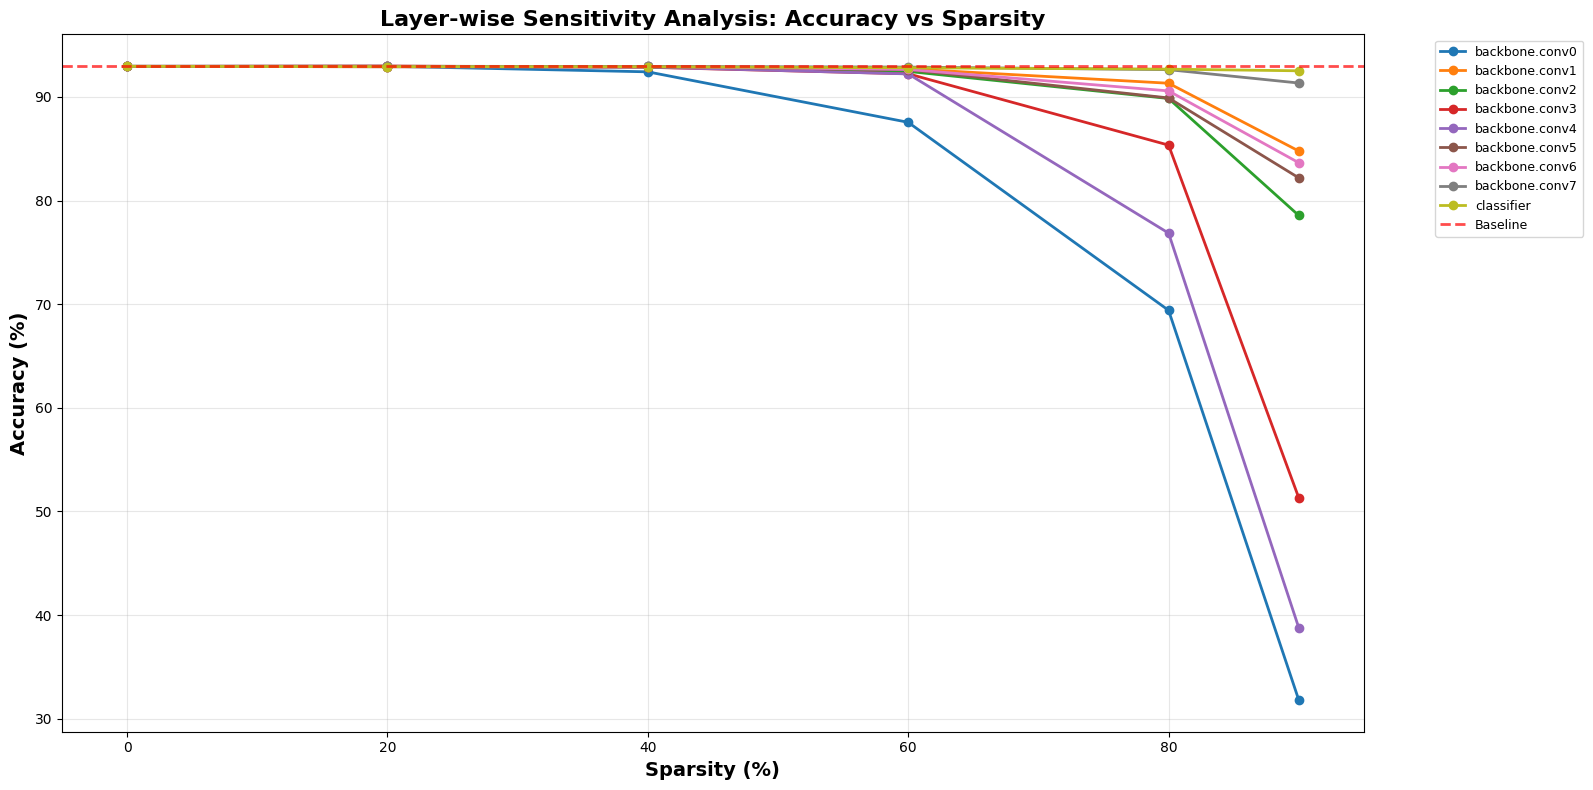

 Saved as sensitivity_accuracy_drop.png


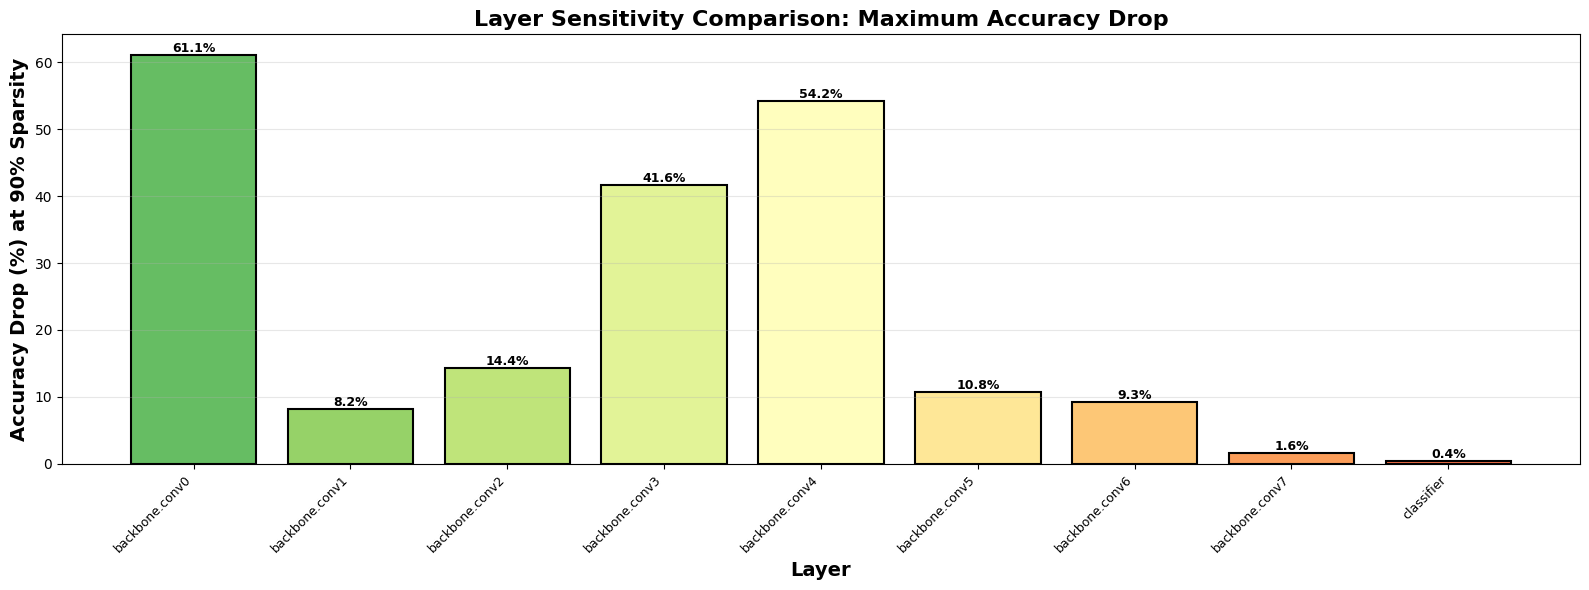

In [50]:
#sensitivity analysis

print("SENSITIVITY ANALYSIS")

def sensitivity_analysis(base_model, testloader, sparsity_ratios=[0.0, 0.2, 0.4, 0.6, 0.8, 0.9]):
    """
    Perform sensitivity analysis by pruning each layer independently
    and measuring the impact on accuracy

    Args:
        base_model: Original model
        testloader: Test data loader
        sparsity_ratios: List of sparsity levels to test

    Returns:
        Dictionary with sensitivity results for each layer
    """
    print("\nStarting sensitivity analysis...")
    print(f"Testing sparsity levels: {[f'{s*100:.0f}%' for s in sparsity_ratios]}\n")

    prunable_layers, layer_names = get_prunable_layers(base_model)
    sensitivity_results = {}

    # baseline accuracy
    baseline_acc = evaluate_model(base_model, testloader)
    print(f"Baseline Model Accuracy: {baseline_acc:.2f}%\n")

    for layer_idx, layer_name in enumerate(layer_names):
        print(f"[{layer_idx+1}/{len(layer_names)}] Analyzing layer: {layer_name}")
        layer_results = []

        for sparsity in sparsity_ratios:
            # copy of the model
            model_copy = copy.deepcopy(base_model)
            model_copy.to(device)

            # prune only this specific layer
            prune_model(model_copy, {layer_name: sparsity})

            # evaluation
            acc = evaluate_model(model_copy, testloader)
            layer_results.append({
                'sparsity': sparsity * 100,
                'accuracy': acc,
                'drop': baseline_acc - acc
            })

            print(f"  Sparsity: {sparsity*100:>4.0f}% -> Accuracy: {acc:>5.2f}% (Drop: {baseline_acc - acc:>5.2f}%)")

            # clean up
            del model_copy
            torch.cuda.empty_cache()

        sensitivity_results[layer_name] = layer_results
        print()

    return sensitivity_results, baseline_acc

def plot_sensitivity_analysis(sensitivity_results, baseline_acc):
    """Plot comprehensive sensitivity analysis results"""

    # Figure 1: Accuracy vs Sparsity for each layer
    fig1, ax1 = plt.subplots(figsize=(16, 8))

    for layer_name, results in sensitivity_results.items():
        sparsities = [r['sparsity'] for r in results]
        accuracies = [r['accuracy'] for r in results]
        ax1.plot(sparsities, accuracies, marker='o', label=layer_name, linewidth=2, markersize=6)

    ax1.axhline(y=baseline_acc, color='red', linestyle='--', linewidth=2, label='Baseline', alpha=0.7)
    ax1.set_xlabel('Sparsity (%)', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
    ax1.set_title('Layer-wise Sensitivity Analysis: Accuracy vs Sparsity', fontsize=16, fontweight='bold')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(-5, 95)
    plt.tight_layout()
    plt.savefig('sensitivity_accuracy_vs_sparsity.png', dpi=150, bbox_inches='tight')
    print("✓ Saved as sensitivity_accuracy_vs_sparsity.png")
    plt.show()

    # Figure 2: Accuracy Drop comparison
    fig2, ax2 = plt.subplots(figsize=(16, 6))

    layer_names = list(sensitivity_results.keys())
    max_drops = []

    for layer_name in layer_names:
        results = sensitivity_results[layer_name]
        max_drop = results[-1]['drop']  # drop at highest sparsity
        max_drops.append(max_drop)

    colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(layer_names)))
    bars = ax2.bar(range(len(layer_names)), max_drops, color=colors, edgecolor='black', linewidth=1.5)

    # add value labels on bars
    for i, (bar, drop) in enumerate(zip(bars, max_drops)):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{drop:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

    ax2.set_xlabel('Layer', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Accuracy Drop (%) at 90% Sparsity', fontsize=14, fontweight='bold')
    ax2.set_title('Layer Sensitivity Comparison: Maximum Accuracy Drop', fontsize=16, fontweight='bold')
    ax2.set_xticks(range(len(layer_names)))
    ax2.set_xticklabels(layer_names, rotation=45, ha='right', fontsize=9)
    ax2.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig('sensitivity_accuracy_drop.png', dpi=150, bbox_inches='tight')
    print(" Saved as sensitivity_accuracy_drop.png")
    plt.show()

print("Running sensitivity analysis (this will take some time)...")
sensitivity_results, baseline_acc = sensitivity_analysis(model, testloader)

print("\nPlotting sensitivity analysis results...")
plot_sensitivity_analysis(sensitivity_results, baseline_acc)


PARAMETER DISTRIBUTION PER LAYER

Plotting parameter distribution...
 Saved as parameter_distribution.png


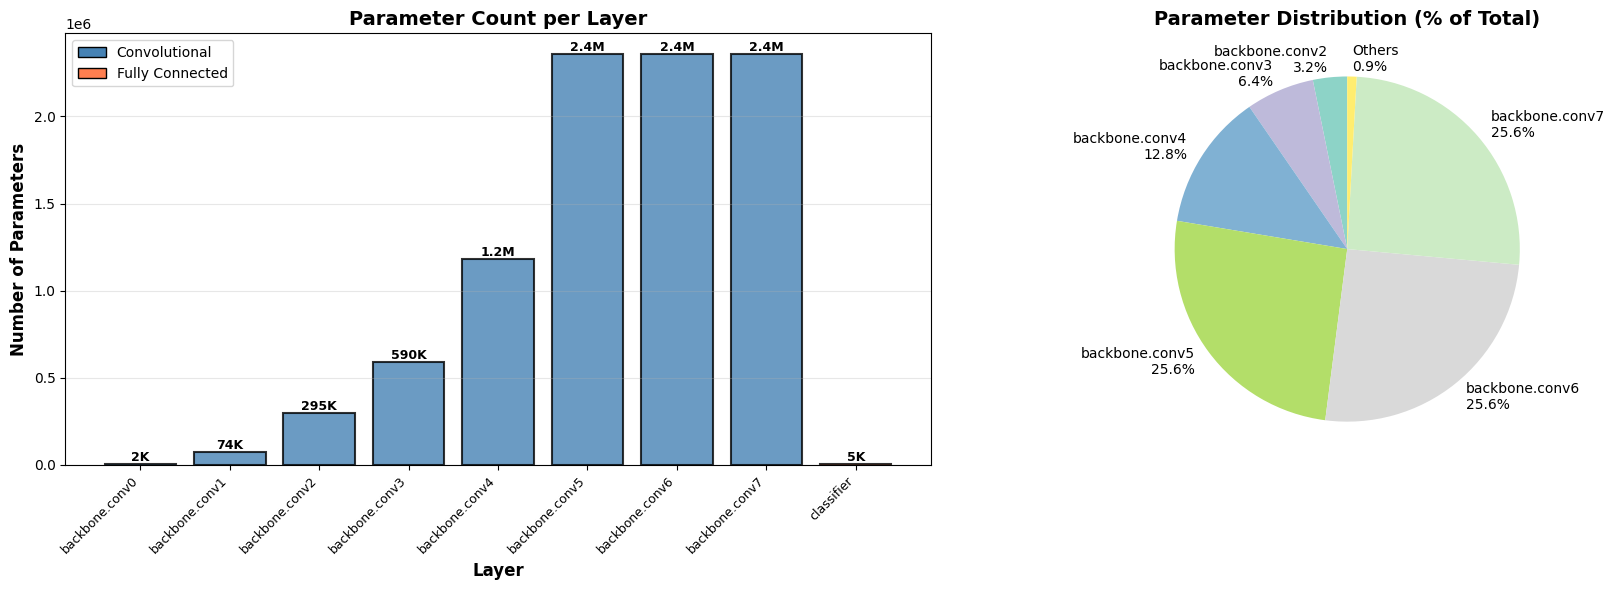


Parameter Distribution Summary:
----------------------------------------------------------------------
Layer                          Type          Parameters   Percentage
----------------------------------------------------------------------
backbone.conv0                 Conv               1,728        0.02%
backbone.conv1                 Conv              73,728        0.80%
backbone.conv2                 Conv             294,912        3.20%
backbone.conv3                 Conv             589,824        6.40%
backbone.conv4                 Conv           1,179,648       12.79%
backbone.conv5                 Conv           2,359,296       25.58%
backbone.conv6                 Conv           2,359,296       25.58%
backbone.conv7                 Conv           2,359,296       25.58%
classifier                     FC                 5,120        0.06%
----------------------------------------------------------------------
TOTAL                                         9,222,848      100

In [51]:
# parameter Distribution per Layer

print("PARAMETER DISTRIBUTION PER LAYER")

def plot_parameter_distribution(model):
    """Plot number of parameters in each layer"""
    prunable_layers, layer_names = get_prunable_layers(model)

    param_counts = []
    layer_types = []

    for layer, name in zip(prunable_layers, layer_names):
        params = layer.weight.numel()
        param_counts.append(params)
        layer_type = 'Conv' if isinstance(layer, nn.Conv2d) else 'FC'
        layer_types.append(layer_type)

    # create plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # plot 1: Bar chart
    colors = ['steelblue' if t == 'Conv' else 'coral' for t in layer_types]
    bars = ax1.bar(range(len(layer_names)), param_counts, color=colors,
                   edgecolor='black', linewidth=1.5, alpha=0.8)

    # add value labels
    for bar, count in zip(bars, param_counts):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{count/1000:.0f}K' if count < 1e6 else f'{count/1e6:.1f}M',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

    ax1.set_xlabel('Layer', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Number of Parameters', fontsize=12, fontweight='bold')
    ax1.set_title('Parameter Count per Layer', fontsize=14, fontweight='bold')
    ax1.set_xticks(range(len(layer_names)))
    ax1.set_xticklabels(layer_names, rotation=45, ha='right', fontsize=9)
    ax1.grid(True, alpha=0.3, axis='y')

    # legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='steelblue', edgecolor='black', label='Convolutional'),
                      Patch(facecolor='coral', edgecolor='black', label='Fully Connected')]
    ax1.legend(handles=legend_elements, loc='upper left', fontsize=10)

    # plot 2: Pie chart
    total_params = sum(param_counts)
    percentages = [100 * p / total_params for p in param_counts]

    # here we will only show layers with > 2% of parameters
    threshold = 2.0
    large_layers = [(name, pct, count) for name, pct, count in zip(layer_names, percentages, param_counts) if pct > threshold]
    other_pct = sum([pct for pct in percentages if pct <= threshold])

    pie_labels = [f'{name}\n{pct:.1f}%' for name, pct, _ in large_layers]
    pie_sizes = [pct for _, pct, _ in large_layers]

    if other_pct > 0:
        pie_labels.append(f'Others\n{other_pct:.1f}%')
        pie_sizes.append(other_pct)

    ax2.pie(pie_sizes, labels=pie_labels, autopct='', startangle=90,
            colors=plt.cm.Set3(np.linspace(0, 1, len(pie_sizes))))
    ax2.set_title('Parameter Distribution (% of Total)', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.savefig('parameter_distribution.png', dpi=150, bbox_inches='tight')
    print(" Saved as parameter_distribution.png")
    plt.show()

    # Print summary table
    print("\nParameter Distribution Summary:")
    print("-" * 70)
    print(f"{'Layer':<30} {'Type':<8} {'Parameters':>15} {'Percentage':>12}")
    print("-" * 70)

    for name, layer_type, count in zip(layer_names, layer_types, param_counts):
        pct = 100 * count / total_params
        print(f"{name:<30} {layer_type:<8} {count:>15,} {pct:>11.2f}%")

    print("-" * 70)
    print(f"{'TOTAL':<30} {'':<8} {total_params:>15,} {100.0:>11.2f}%")
    print("-" * 70)

print("\nPlotting parameter distribution...")
plot_parameter_distribution(model)

In [52]:
# sparsity Assignment

print("STEP 7: MANUAL SPARSITY ASSIGNMENT - TARGET 70% OVERALL")

# layer names
prunable_layers, layer_names = get_prunable_layers(model)

print("\nAvailable layers to prune:")
for idx, name in enumerate(layer_names):
    print(f"  {idx+1}. {name}")

custom_sparsity = {
    'backbone.conv0': 0.40,   # low num of parameters and highly sensitive so assigning low sparsity
    'backbone.conv1': 0.50,
    'backbone.conv2': 0.55,
    'backbone.conv3': 0.55,
    'backbone.conv4': 0.65,
    'backbone.conv5': 0.75,
    'backbone.conv6': 0.75,   # late conv - higher sparsity
    'backbone.conv7': 0.75,
    'classifier': 0.00
}

print("\n sparsity configuration:")
for name, sparsity in custom_sparsity.items():
    print(f"  {name:<20} : {sparsity*100:>5.1f}%")


STEP 7: MANUAL SPARSITY ASSIGNMENT - TARGET 70% OVERALL

Available layers to prune:
  1. backbone.conv0
  2. backbone.conv1
  3. backbone.conv2
  4. backbone.conv3
  5. backbone.conv4
  6. backbone.conv5
  7. backbone.conv6
  8. backbone.conv7
  9. classifier

 sparsity configuration:
  backbone.conv0       :  40.0%
  backbone.conv1       :  50.0%
  backbone.conv2       :  55.0%
  backbone.conv3       :  55.0%
  backbone.conv4       :  65.0%
  backbone.conv5       :  75.0%
  backbone.conv6       :  75.0%
  backbone.conv7       :  75.0%
  classifier           :   0.0%


STEP 8: APPLYING PRUNING

 Target Sparsity: 70.0%
 Achieved Sparsity: 71.55%

Evaluating pruned model...



 Base Accuracy: 92.95%
 Pruned Accuracy: 89.51%
 Accuracy Drop: 3.44%

Plotting weight distribution after pruning...
 Saved as weights_after_pruning.png


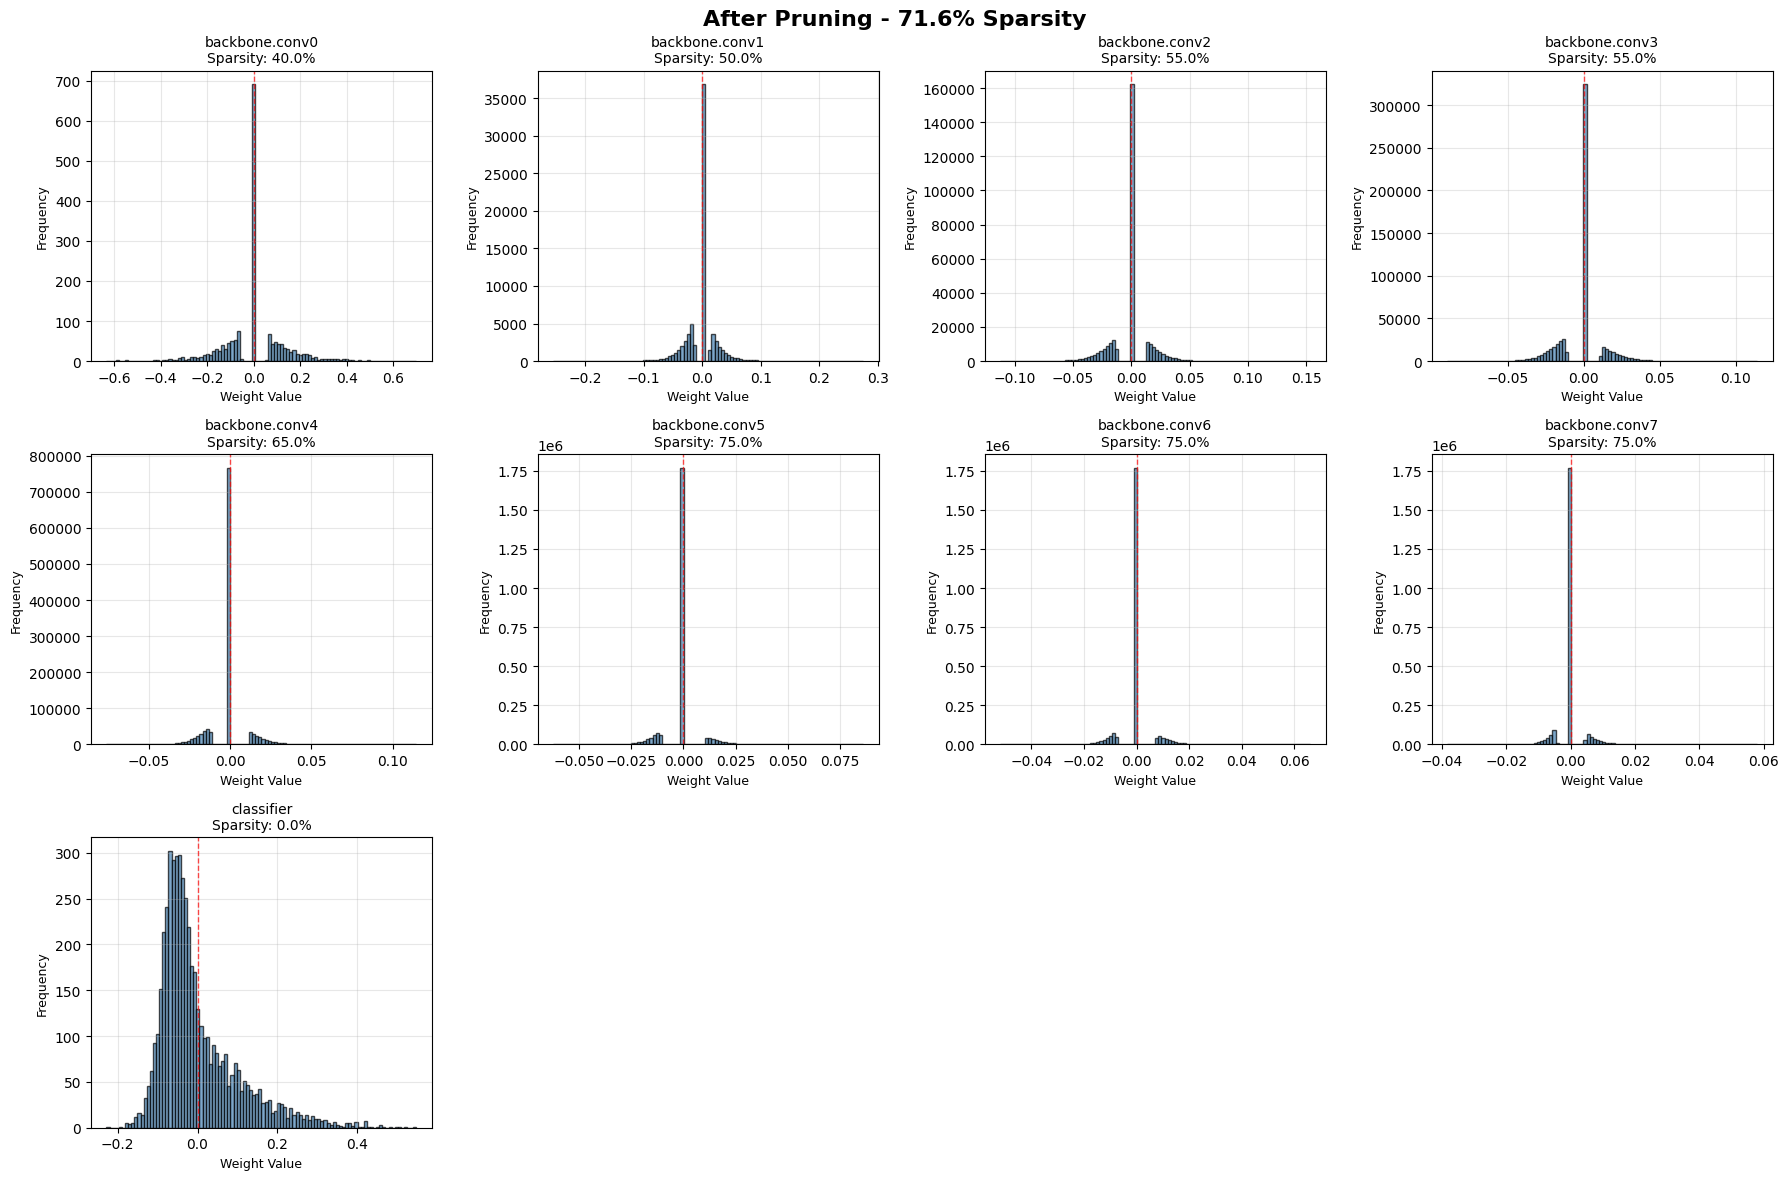


 Pruned model saved!


In [53]:
# applying pruning here now
print("STEP 8: APPLYING PRUNING")

# create pruned model
pruned_model = copy.deepcopy(model)
pruned_model = prune_model(pruned_model, custom_sparsity)

# calculate sparsity
overall_sparsity = calculate_sparsity(pruned_model)
print(f"\n Target Sparsity: 70.0%")
print(f" Achieved Sparsity: {overall_sparsity:.2f}%")

# Evaluate pruned model
print("\nEvaluating pruned model...")
pruned_accuracy = evaluate_model(pruned_model, testloader)
accuracy_drop = base_accuracy - pruned_accuracy

print(f"\n Base Accuracy: {base_accuracy:.2f}%")
print(f" Pruned Accuracy: {pruned_accuracy:.2f}%")
print(f" Accuracy Drop: {accuracy_drop:.2f}%")

# Visualize weight distribution after pruning
print("\nPlotting weight distribution after pruning...")
plot_weight_distribution(pruned_model,
                        f"After Pruning - {overall_sparsity:.1f}% Sparsity",
                        "weights_after_pruning.png")

# Save pruned model
torch.save({
    'model_state': pruned_model.state_dict(),
    'sparsity_config': custom_sparsity,
    'overall_sparsity': overall_sparsity,
    'base_accuracy': base_accuracy,
    'pruned_accuracy': pruned_accuracy,
}, 'vgg11_pruned_unstructured.pth')

print("\n Pruned model saved!")

STRUCTURED PRUNING

In [54]:
# utility functions
def evaluate_model(model, testloader):
    """Evaluate model accuracy"""
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc="Evaluating", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return 100. * correct / total

def count_parameters(model):
    """Count total parameters"""
    return sum(p.numel() for p in model.parameters())

def calculate_model_size(model):
    """Calculate total parameters, trainable parameters, and model size in MB"""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    # model size in MB
    param_size = sum(p.numel() * p.element_size() for p in model.parameters())
    buffer_size = sum(b.numel() * b.element_size() for b in model.buffers())
    size_mb = (param_size + buffer_size) / (1024 ** 2)

    return total_params, trainable_params, size_mb

# evaluate base model
base_accuracy = evaluate_model(model, testloader)
base_params = count_parameters(model)
base_size = calculate_model_size(model)[2] # Only need size for this print, full tuple for later

print(f"\n Base Model Accuracy: {base_accuracy:.2f}%")
print(f" Base Parameters: {base_params:,}")
print(f" Base Size: {base_size:.2f} MB")


 Base Model Accuracy: 92.95%
 Base Parameters: 9,228,362
 Base Size: 35.22 MB


In [55]:
# structured pruning functions

def get_conv_layers(model):
    """Get all convolutional layers"""
    conv_layers = []
    layer_names = []

    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            conv_layers.append(module)
            layer_names.append(name)

    return conv_layers, layer_names

def calculate_channel_importance(conv_layer):
    """
    Calculate importance of each output channel using L1-norm
    Higher norm = more important channel

    For a conv layer with shape [out_channels, in_channels, k, k]:
    - Calculate L1-norm across [in_channels, k, k] for each output channel
    """
    weights = conv_layer.weight.data  # [out_ch, in_ch, k, k]

    # L1-norm for each output channel
    importance = torch.sum(torch.abs(weights), dim=(1, 2, 3))  # [out_ch]

    return importance

def prune_conv_layer(conv_layer, bn_layer, next_conv_layer, keep_ratio):
    """
    Prune a convolutional layer by removing least important channels

    Steps:
    1. Calculate channel importance
    2. Select channels to keep
    3. Prune current layer's output channels
    4. Prune BatchNorm parameters
    5. Prune next layer's input channels

    Args:
        conv_layer: Current conv layer to prune
        bn_layer: Corresponding BatchNorm layer
        next_conv_layer: Next conv layer (or classifier)
        keep_ratio: Fraction of channels to keep (e.g., 0.5 = keep 50%)
    """
    if conv_layer is None:
        return

    # calculate importance
    importance = calculate_channel_importance(conv_layer)
    num_channels = len(importance)
    num_keep = int(num_channels * keep_ratio)
    num_keep = max(num_keep, 1)  # Keep at least 1 channel

    # select channels to keep (top-k most important)
    _, indices = torch.topk(importance, num_keep)
    indices = sorted(indices.tolist())

    # prune current conv layer output channels
    conv_layer.weight = nn.Parameter(conv_layer.weight.data[indices, :, :, :])
    conv_layer.out_channels = num_keep

    # prune BatchNorm
    if bn_layer is not None:
        bn_layer.weight = nn.Parameter(bn_layer.weight.data[indices])
        bn_layer.bias = nn.Parameter(bn_layer.bias.data[indices])
        bn_layer.running_mean = bn_layer.running_mean[indices]
        bn_layer.running_var = bn_layer.running_var[indices]
        bn_layer.num_features = num_keep

    # prune next layer input channels
    if next_conv_layer is not None:
        if isinstance(next_conv_layer, nn.Conv2d):
            next_conv_layer.weight = nn.Parameter(
                next_conv_layer.weight.data[:, indices, :, :]
            )
            next_conv_layer.in_channels = num_keep
        elif isinstance(next_conv_layer, nn.Linear):
            # For classifier, need to adjust based on spatial size
            # After GAP, feature size = num_keep
            next_conv_layer.weight = nn.Parameter(
                next_conv_layer.weight.data[:, indices]
            )
            next_conv_layer.in_features = num_keep

def apply_structured_pruning(model, prune_ratios):
    """
    Apply structured pruning to the entire model

    Args:
        model: VGG model
        prune_ratios: dict mapping layer names to keep ratios
                     e.g., {'backbone.conv0': 0.5} means keep 50% of channels
    """
    conv_layers, conv_names = get_conv_layers(model)

    for i, (conv_name, conv_layer) in enumerate(zip(conv_names, conv_layers)):
        if conv_name not in prune_ratios:
            continue

        keep_ratio = prune_ratios[conv_name]

        # corresponding BatchNorm layer
        bn_name = conv_name.replace('conv', 'bn')
        bn_layer = None
        for name, module in model.named_modules():
            if name == bn_name and isinstance(module, nn.BatchNorm2d):
                bn_layer = module
                break

        # next conv layer or classifier
        next_conv_layer = None
        if i + 1 < len(conv_layers):
            next_conv_layer = conv_layers[i + 1]
        else:
            # last conv connects to classifier
            next_conv_layer = model.classifier

        # apply pruning
        print(f"Pruning {conv_name}: keeping {keep_ratio*100:.0f}% channels", end="")
        old_channels = conv_layer.out_channels
        prune_conv_layer(conv_layer, bn_layer, next_conv_layer, keep_ratio)
        new_channels = conv_layer.out_channels
        print(f" ({old_channels} → {new_channels})")

    return model

In [56]:
# visualization functions

def plot_weight_distribution_structured(model, title="Weight Distribution", save_name=None):
    """Plot weight distribution for conv layers"""
    conv_layers, layer_names = get_conv_layers(model)

    n_layers = len(conv_layers)
    n_cols = 4
    n_rows = (n_layers + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4*n_rows))
    axes = axes.flatten() if n_layers > 1 else [axes]

    for idx, (layer, name) in enumerate(zip(conv_layers, layer_names)):
        weights = layer.weight.data.cpu().numpy().flatten()

        ax = axes[idx]
        ax.hist(weights, bins=100, alpha=0.7, edgecolor='black', color='steelblue')
        ax.set_title(f'{name}\nChannels: {layer.out_channels}', fontsize=10)
        ax.set_xlabel('Weight Value', fontsize=9)
        ax.set_ylabel('Frequency', fontsize=9)
        ax.grid(True, alpha=0.3)
        ax.axvline(x=0, color='red', linestyle='--', linewidth=1, alpha=0.7)

    for idx in range(n_layers, len(axes)):
        axes[idx].axis('off')

    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()

    if save_name:
        plt.savefig(save_name, dpi=150, bbox_inches='tight')
        print(f" Saved as {save_name}")

    plt.show()

WEIGHT DISTRIBUTION - BEFORE STRUCTURED PRUNING
 Saved as weights_before_structured.png


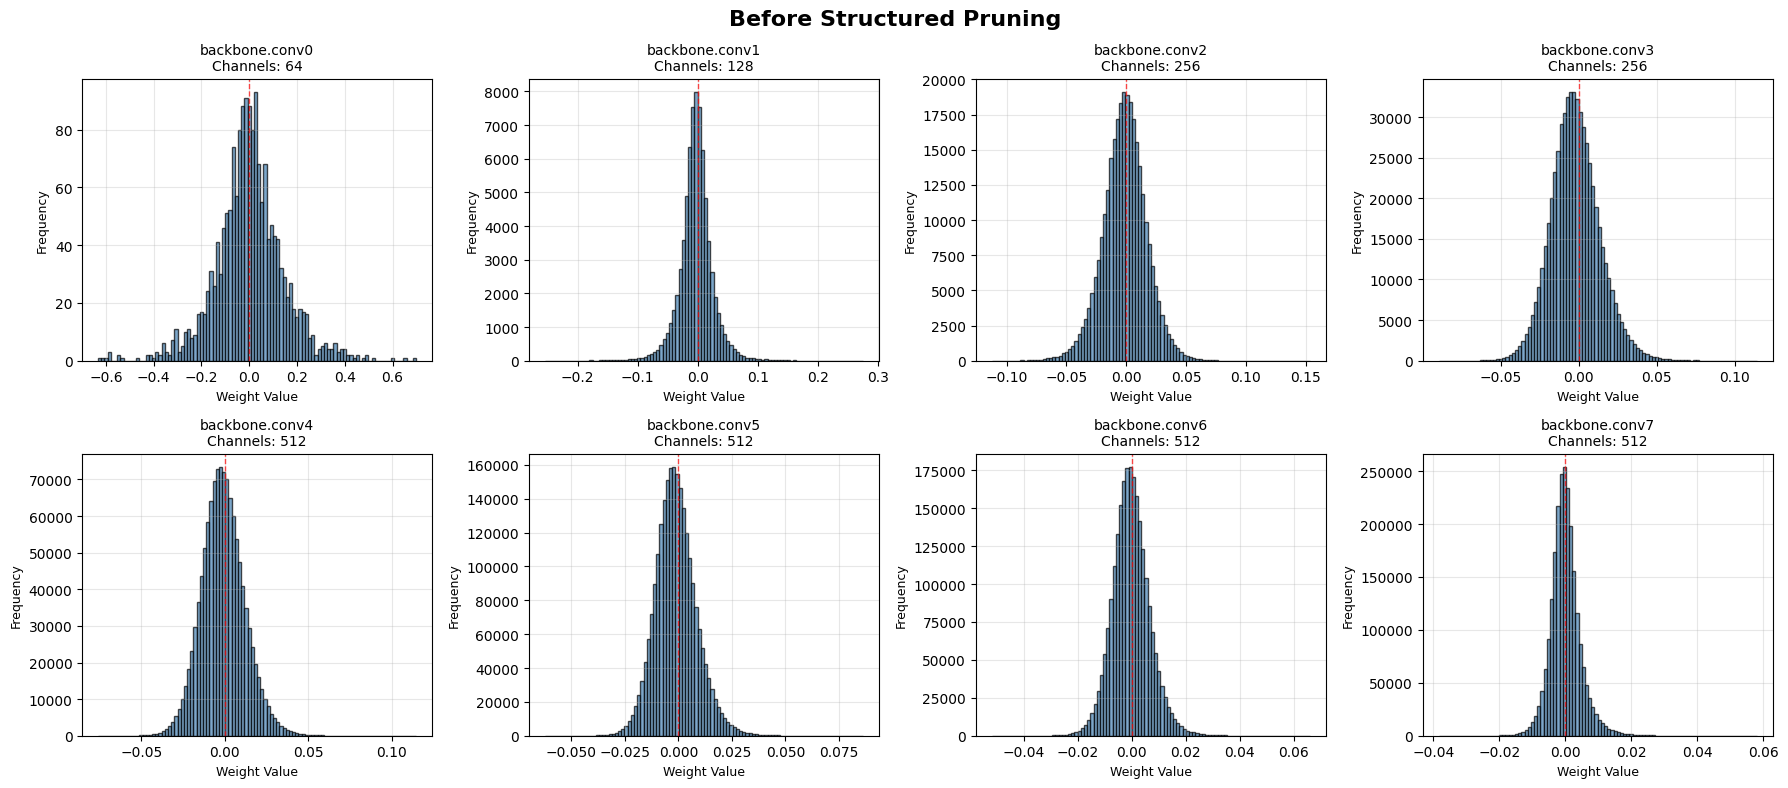

In [57]:
# BEFORE PRUNING VISUALIZATION
print("WEIGHT DISTRIBUTION - BEFORE STRUCTURED PRUNING")

plot_weight_distribution_structured(model, "Before Structured Pruning",
                                   "weights_before_structured.png")

SENSITIVITY ANALYSIS FOR STRUCTURED PRUNING
Running sensitivity analysis...

Testing keep ratios: ['100%', '80%', '60%', '40%', '20%']

[1/8] Analyzing backbone.conv0
Pruning backbone.conv0: keeping 100% channels (64 → 64)


  Keep  100% → Accuracy: 92.95% (Drop:  0.00%)
Pruning backbone.conv0: keeping 80% channels (64 → 51)


  Keep   80% → Accuracy: 92.56% (Drop:  0.39%)
Pruning backbone.conv0: keeping 60% channels (64 → 38)


  Keep   60% → Accuracy: 91.79% (Drop:  1.16%)
Pruning backbone.conv0: keeping 40% channels (64 → 25)


  Keep   40% → Accuracy: 88.02% (Drop:  4.93%)
Pruning backbone.conv0: keeping 20% channels (64 → 12)


  Keep   20% → Accuracy: 51.49% (Drop: 41.46%)

[2/8] Analyzing backbone.conv1
Pruning backbone.conv1: keeping 100% channels (128 → 128)


  Keep  100% → Accuracy: 92.95% (Drop:  0.00%)
Pruning backbone.conv1: keeping 80% channels (128 → 102)


  Keep   80% → Accuracy: 90.60% (Drop:  2.35%)
Pruning backbone.conv1: keeping 60% channels (128 → 76)


  Keep   60% → Accuracy: 77.34% (Drop: 15.61%)
Pruning backbone.conv1: keeping 40% channels (128 → 51)


  Keep   40% → Accuracy: 40.78% (Drop: 52.17%)
Pruning backbone.conv1: keeping 20% channels (128 → 25)


  Keep   20% → Accuracy: 22.05% (Drop: 70.90%)

[3/8] Analyzing backbone.conv2
Pruning backbone.conv2: keeping 100% channels (256 → 256)


  Keep  100% → Accuracy: 92.95% (Drop:  0.00%)
Pruning backbone.conv2: keeping 80% channels (256 → 204)


  Keep   80% → Accuracy: 90.37% (Drop:  2.58%)
Pruning backbone.conv2: keeping 60% channels (256 → 153)


  Keep   60% → Accuracy: 77.06% (Drop: 15.89%)
Pruning backbone.conv2: keeping 40% channels (256 → 102)


  Keep   40% → Accuracy: 49.85% (Drop: 43.10%)
Pruning backbone.conv2: keeping 20% channels (256 → 51)


  Keep   20% → Accuracy: 16.86% (Drop: 76.09%)

[4/8] Analyzing backbone.conv3
Pruning backbone.conv3: keeping 100% channels (256 → 256)


  Keep  100% → Accuracy: 92.95% (Drop:  0.00%)
Pruning backbone.conv3: keeping 80% channels (256 → 204)


  Keep   80% → Accuracy: 90.64% (Drop:  2.31%)
Pruning backbone.conv3: keeping 60% channels (256 → 153)


  Keep   60% → Accuracy: 82.22% (Drop: 10.73%)
Pruning backbone.conv3: keeping 40% channels (256 → 102)


  Keep   40% → Accuracy: 62.75% (Drop: 30.20%)
Pruning backbone.conv3: keeping 20% channels (256 → 51)


  Keep   20% → Accuracy: 24.83% (Drop: 68.12%)

[5/8] Analyzing backbone.conv4
Pruning backbone.conv4: keeping 100% channels (512 → 512)


  Keep  100% → Accuracy: 92.95% (Drop:  0.00%)
Pruning backbone.conv4: keeping 80% channels (512 → 409)


  Keep   80% → Accuracy: 90.99% (Drop:  1.96%)
Pruning backbone.conv4: keeping 60% channels (512 → 307)


  Keep   60% → Accuracy: 85.35% (Drop:  7.60%)
Pruning backbone.conv4: keeping 40% channels (512 → 204)


  Keep   40% → Accuracy: 68.55% (Drop: 24.40%)
Pruning backbone.conv4: keeping 20% channels (512 → 102)


  Keep   20% → Accuracy: 38.05% (Drop: 54.90%)

[6/8] Analyzing backbone.conv5
Pruning backbone.conv5: keeping 100% channels (512 → 512)


  Keep  100% → Accuracy: 92.95% (Drop:  0.00%)
Pruning backbone.conv5: keeping 80% channels (512 → 409)


  Keep   80% → Accuracy: 91.61% (Drop:  1.34%)
Pruning backbone.conv5: keeping 60% channels (512 → 307)


  Keep   60% → Accuracy: 83.95% (Drop:  9.00%)
Pruning backbone.conv5: keeping 40% channels (512 → 204)


  Keep   40% → Accuracy: 65.72% (Drop: 27.23%)
Pruning backbone.conv5: keeping 20% channels (512 → 102)


  Keep   20% → Accuracy: 38.54% (Drop: 54.41%)

[7/8] Analyzing backbone.conv6
Pruning backbone.conv6: keeping 100% channels (512 → 512)


  Keep  100% → Accuracy: 92.95% (Drop:  0.00%)
Pruning backbone.conv6: keeping 80% channels (512 → 409)


  Keep   80% → Accuracy: 92.40% (Drop:  0.55%)
Pruning backbone.conv6: keeping 60% channels (512 → 307)


  Keep   60% → Accuracy: 88.98% (Drop:  3.97%)
Pruning backbone.conv6: keeping 40% channels (512 → 204)


  Keep   40% → Accuracy: 76.52% (Drop: 16.43%)
Pruning backbone.conv6: keeping 20% channels (512 → 102)


  Keep   20% → Accuracy: 62.79% (Drop: 30.16%)

[8/8] Analyzing backbone.conv7
Pruning backbone.conv7: keeping 100% channels (512 → 512)


  Keep  100% → Accuracy: 92.95% (Drop:  0.00%)
Pruning backbone.conv7: keeping 80% channels (512 → 409)


  Keep   80% → Accuracy: 92.91% (Drop:  0.04%)
Pruning backbone.conv7: keeping 60% channels (512 → 307)


  Keep   60% → Accuracy: 92.04% (Drop:  0.91%)
Pruning backbone.conv7: keeping 40% channels (512 → 204)


  Keep   40% → Accuracy: 88.53% (Drop:  4.42%)
Pruning backbone.conv7: keeping 20% channels (512 → 102)


  Keep   20% → Accuracy: 79.74% (Drop: 13.21%)


Plotting sensitivity results...
 Saved sensitivity_structured_accuracy.png


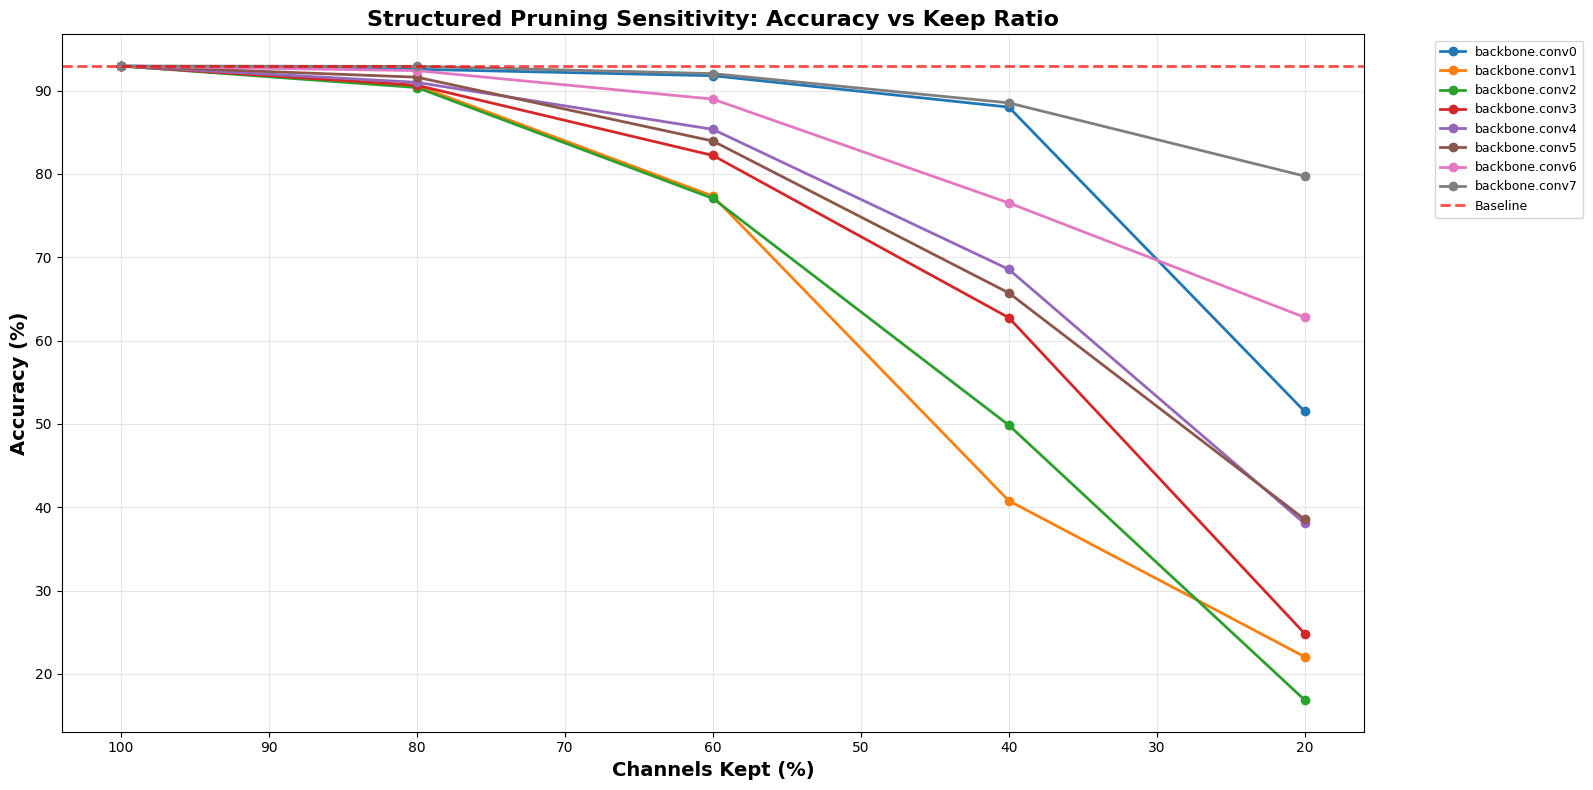

 Saved sensitivity_structured_drops.png


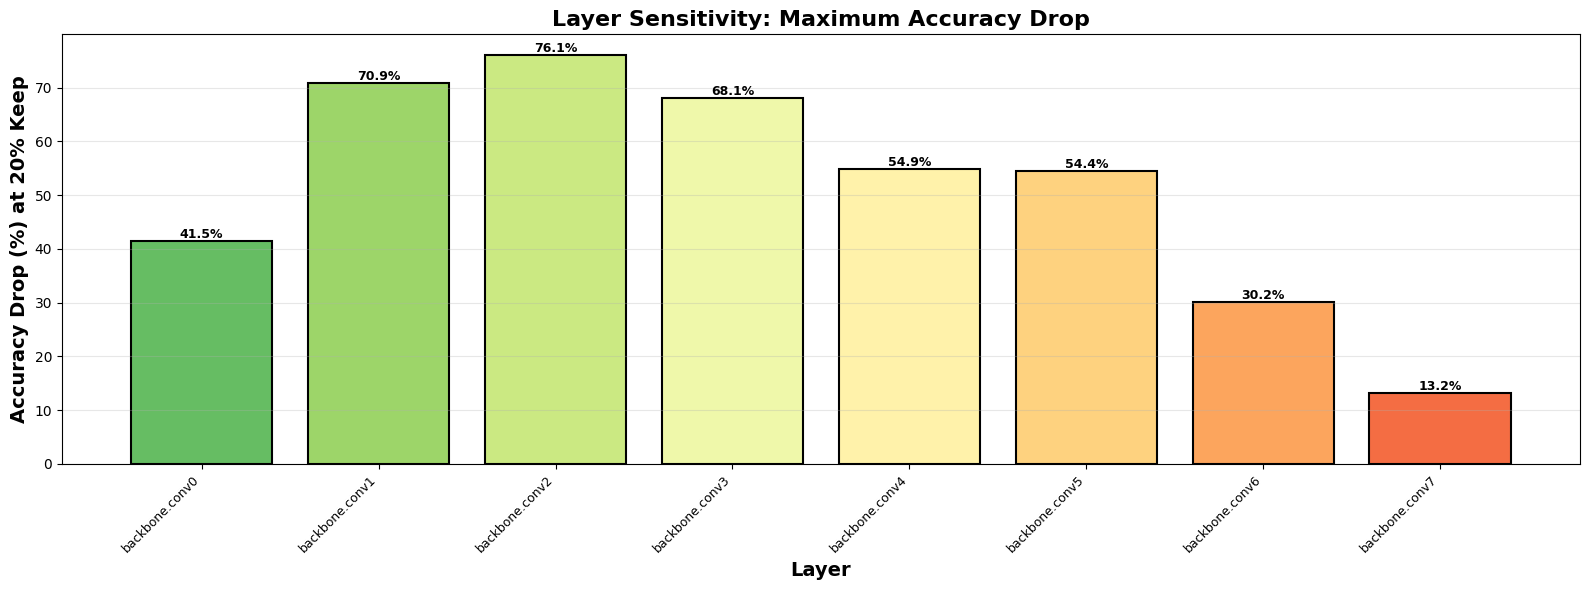

In [58]:
# SENSITIVITY ANALYSIS

print("SENSITIVITY ANALYSIS FOR STRUCTURED PRUNING")

def sensitivity_analysis_structured(base_model, testloader, keep_ratios=[1.0, 0.8, 0.6, 0.4, 0.2]):
    """
    Perform sensitivity analysis for structured pruning
    Test each layer independently
    """
    conv_layers, layer_names = get_conv_layers(base_model)
    sensitivity_results = {}

    print(f"\nTesting keep ratios: {[f'{k*100:.0f}%' for k in keep_ratios]}\n")

    for layer_idx, layer_name in enumerate(layer_names):
        print(f"[{layer_idx+1}/{len(layer_names)}] Analyzing {layer_name}")
        layer_results = []

        for keep_ratio in keep_ratios:
            # create copy
            model_copy = copy.deepcopy(base_model)
            model_copy.to(device)

            # prune only this layer
            try:
                apply_structured_pruning(model_copy, {layer_name: keep_ratio})
                acc = evaluate_model(model_copy, testloader)
            except Exception as e:
                print(f"  Error at {keep_ratio*100:.0f}%: {e}")
                acc = 0.0

            pruned_pct = (1 - keep_ratio) * 100
            layer_results.append({
                'prune_ratio': pruned_pct,
                'keep_ratio': keep_ratio * 100,
                'accuracy': acc,
                'drop': base_accuracy - acc
            })

            print(f"  Keep {keep_ratio*100:>4.0f}% → Accuracy: {acc:>5.2f}% (Drop: {base_accuracy - acc:>5.2f}%)")

            del model_copy
            torch.cuda.empty_cache()

        sensitivity_results[layer_name] = layer_results
        print()

    return sensitivity_results

def plot_sensitivity_structured(sensitivity_results, base_acc):
    """Plot sensitivity analysis results"""

    # Figure 1: Accuracy vs Keep Ratio
    fig1, ax1 = plt.subplots(figsize=(16, 8))

    for layer_name, results in sensitivity_results.items():
        keep_ratios = [r['keep_ratio'] for r in results]
        accuracies = [r['accuracy'] for r in results]
        ax1.plot(keep_ratios, accuracies, marker='o', label=layer_name,
                linewidth=2, markersize=6)

    ax1.axhline(y=base_acc, color='red', linestyle='--', linewidth=2,
                label='Baseline', alpha=0.7)
    ax1.set_xlabel('Channels Kept (%)', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
    ax1.set_title('Structured Pruning Sensitivity: Accuracy vs Keep Ratio',
                 fontsize=16, fontweight='bold')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    ax1.grid(True, alpha=0.3)
    ax1.invert_xaxis()  # higher keep ratio on left
    plt.tight_layout()
    plt.savefig('sensitivity_structured_accuracy.png', dpi=150, bbox_inches='tight')
    print(" Saved sensitivity_structured_accuracy.png")
    plt.show()

    # Figure 2: Accuracy Drop Comparison
    fig2, ax2 = plt.subplots(figsize=(16, 6))

    layer_names = list(sensitivity_results.keys())
    max_drops = []

    for layer_name in layer_names:
        results = sensitivity_results[layer_name]
        # Drop when keeping only 20%
        max_drop = results[-1]['drop']
        max_drops.append(max_drop)

    colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(layer_names)))
    bars = ax2.bar(range(len(layer_names)), max_drops, color=colors,
                   edgecolor='black', linewidth=1.5)

    for i, (bar, drop) in enumerate(zip(bars, max_drops)):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{drop:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

    ax2.set_xlabel('Layer', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Accuracy Drop (%) at 20% Keep', fontsize=14, fontweight='bold')
    ax2.set_title('Layer Sensitivity: Maximum Accuracy Drop', fontsize=16, fontweight='bold')
    ax2.set_xticks(range(len(layer_names)))
    ax2.set_xticklabels(layer_names, rotation=45, ha='right', fontsize=9)
    ax2.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig('sensitivity_structured_drops.png', dpi=150, bbox_inches='tight')
    print(" Saved sensitivity_structured_drops.png")
    plt.show()

print("Running sensitivity analysis...")
sensitivity_results = sensitivity_analysis_structured(model, testloader)

print("\nPlotting sensitivity results...")
plot_sensitivity_structured(sensitivity_results, base_accuracy)

CHANNEL DISTRIBUTION ANALYSIS
 Saved channel_distribution.png


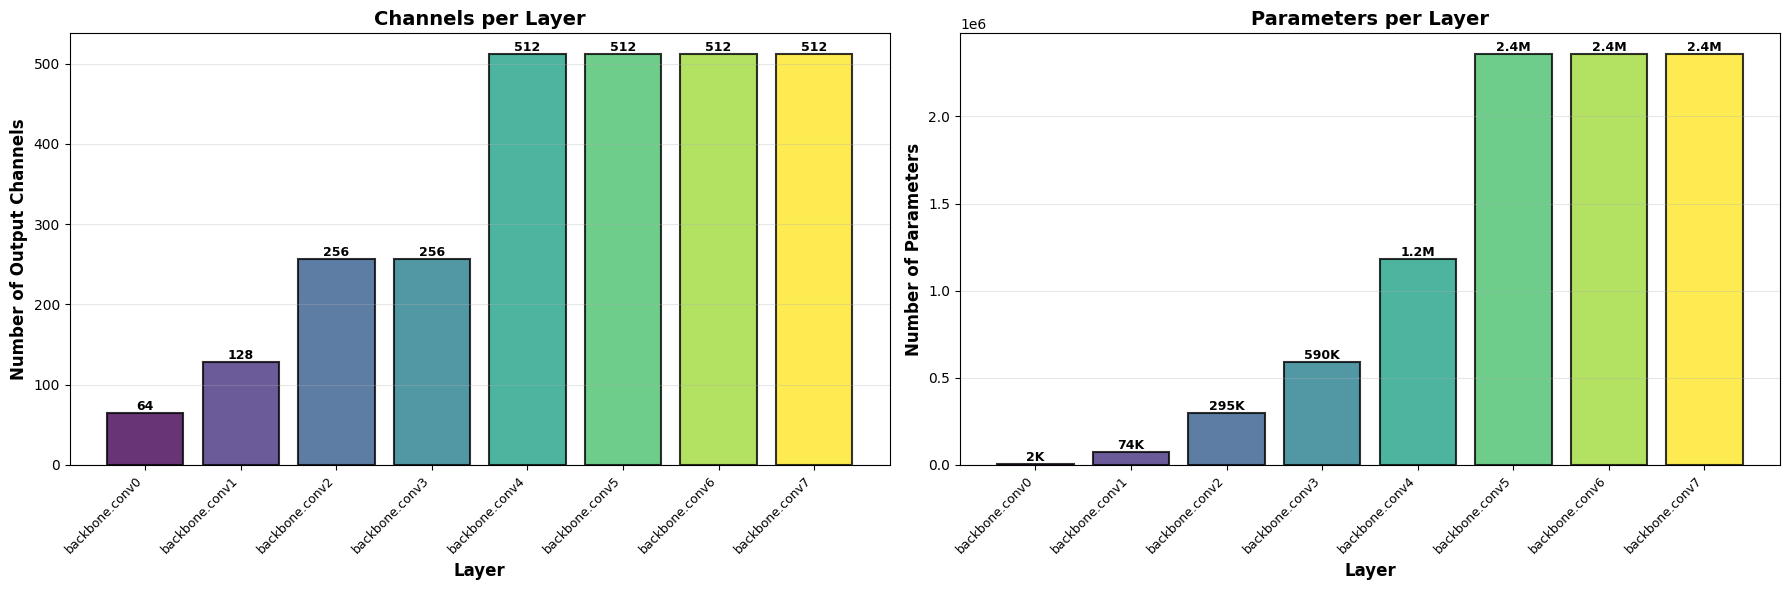


Channel Distribution Summary:
Layer                   Output Channels           Parameters      % of Total
backbone.conv0                       64                1,728           0.02%
backbone.conv1                      128               73,728           0.80%
backbone.conv2                      256              294,912           3.20%
backbone.conv3                      256              589,824           6.40%
backbone.conv4                      512            1,179,648          12.80%
backbone.conv5                      512            2,359,296          25.60%
backbone.conv6                      512            2,359,296          25.60%
backbone.conv7                      512            2,359,296          25.60%
TOTAL                                              9,217,728         100.00%


In [59]:
# CHANNEL DISTRIBUTION

print("CHANNEL DISTRIBUTION ANALYSIS")

def plot_channel_distribution(model):
    """Plot number of channels per layer"""
    conv_layers, layer_names = get_conv_layers(model)

    channel_counts = [layer.out_channels for layer in conv_layers]
    param_counts = [layer.weight.numel() for layer in conv_layers]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # Plot 1: channel counts
    colors = plt.cm.viridis(np.linspace(0, 1, len(layer_names)))
    bars1 = ax1.bar(range(len(layer_names)), channel_counts, color=colors,
                    edgecolor='black', linewidth=1.5, alpha=0.8)

    for bar, count in zip(bars1, channel_counts):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{count}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    ax1.set_xlabel('Layer', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Number of Output Channels', fontsize=12, fontweight='bold')
    ax1.set_title('Channels per Layer', fontsize=14, fontweight='bold')
    ax1.set_xticks(range(len(layer_names)))
    ax1.set_xticklabels(layer_names, rotation=45, ha='right', fontsize=9)
    ax1.grid(True, alpha=0.3, axis='y')

    # Plot 2: parameter counts
    bars2 = ax2.bar(range(len(layer_names)), param_counts, color=colors,
                    edgecolor='black', linewidth=1.5, alpha=0.8)

    for bar, count in zip(bars2, param_counts):
        height = bar.get_height()
        label = f'{count/1000:.0f}K' if count < 1e6 else f'{count/1e6:.1f}M'
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                label, ha='center', va='bottom', fontsize=9, fontweight='bold')

    ax2.set_xlabel('Layer', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Number of Parameters', fontsize=12, fontweight='bold')
    ax2.set_title('Parameters per Layer', fontsize=14, fontweight='bold')
    ax2.set_xticks(range(len(layer_names)))
    ax2.set_xticklabels(layer_names, rotation=45, ha='right', fontsize=9)
    ax2.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig('channel_distribution.png', dpi=150, bbox_inches='tight')
    print(" Saved channel_distribution.png")
    plt.show()

    # Print table
    print("\nChannel Distribution Summary:")

    print(f"{'Layer':<20} {'Output Channels':>18} {'Parameters':>20} {'% of Total':>15}")

    total_params = sum(param_counts)
    for name, channels, params in zip(layer_names, channel_counts, param_counts):
        pct = 100 * params / total_params
        print(f"{name:<20} {channels:>18} {params:>20,} {pct:>14.2f}%")

    print(f"{'TOTAL':<20} {'':<18} {total_params:>20,} {100.0:>14.2f}%")

plot_channel_distribution(model)

In [60]:
# MANUAL PRUNING CONFIGURATION

# (1.0 = keep all, 0.3 = keep 30%)
prune_config2 = {
    'backbone.conv0': 0.90,  # Early - keep more
    'backbone.conv1': 0.70,
    'backbone.conv2': 0.80,  # #Mid highest accuracy drop so keeping higher ratio
    'backbone.conv3': 0.60,
    'backbone.conv4': 0.65,
    'backbone.conv5': 0.65,
    'backbone.conv6': 0.40,  # Late - prune more
    'backbone.conv7': 0.40,
}

print("\n Your configuration (keep ratios):")
for name, ratio in prune_config2.items():
    print(f"  {name:<20} → Keep {ratio*100:>5.1f}% (prune {(1-ratio)*100:>5.1f}%)")

# Estimate resulting size
def estimate_pruned_params(model, config):
    """Estimate parameters after pruning"""
    conv_layers, layer_names = get_conv_layers(model)

    # Track channel counts through network
    channel_counts = [3]  # Input channels
    for layer in conv_layers:
        channel_counts.append(layer.out_channels)

    total_params_after = 0

    for i, (layer, name) in enumerate(zip(conv_layers, layer_names)):
        if name in config:
            out_ch = int(layer.out_channels * config[name])
        else:
            out_ch = layer.out_channels

        in_ch = int(channel_counts[i] * config.get(layer_names[i-1], 1.0)) if i > 0 else channel_counts[i]

        # Conv params: out_ch * in_ch * k * k
        params = out_ch * in_ch * 3 * 3
        total_params_after += params

    # Classifier params
    last_conv_name = layer_names[-1]
    final_channels = int(conv_layers[-1].out_channels * config.get(last_conv_name, 1.0))
    total_params_after += final_channels * 10  # classifier

    return total_params_after

estimated_params = estimate_pruned_params(model, prune_config2)
retention_pct = 100 * estimated_params / base_params
reduction_pct = 100 - retention_pct

print(f"\n ESTIMATED RESULTS:")
print(f"  Base parameters: {base_params:,}")
print(f"  Estimated after pruning: {estimated_params:,}")
print(f"  Retention: {retention_pct:.1f}%")
print(f"  Reduction: {reduction_pct:.1f}%")



 Your configuration (keep ratios):
  backbone.conv0       → Keep  90.0% (prune  10.0%)
  backbone.conv1       → Keep  70.0% (prune  30.0%)
  backbone.conv2       → Keep  80.0% (prune  20.0%)
  backbone.conv3       → Keep  60.0% (prune  40.0%)
  backbone.conv4       → Keep  65.0% (prune  35.0%)
  backbone.conv5       → Keep  65.0% (prune  35.0%)
  backbone.conv6       → Keep  40.0% (prune  60.0%)
  backbone.conv7       → Keep  40.0% (prune  60.0%)

 ESTIMATED RESULTS:
  Base parameters: 9,228,362
  Estimated after pruning: 2,926,824
  Retention: 31.7%
  Reduction: 68.3%


APPLYING STRUCTURED PRUNING
Pruning backbone.conv0: keeping 90% channels (64 → 57)
Pruning backbone.conv1: keeping 70% channels (128 → 89)
Pruning backbone.conv2: keeping 80% channels (256 → 204)
Pruning backbone.conv3: keeping 60% channels (256 → 153)
Pruning backbone.conv4: keeping 65% channels (512 → 332)
Pruning backbone.conv5: keeping 65% channels (512 → 332)
Pruning backbone.conv6: keeping 40% channels (512 → 204)
Pruning backbone.conv7: keeping 40% channels (512 → 204)

 ACTUAL RESULTS:
  Parameters: 9,228,362 → 2,929,984
  Retention: 31.7%
  Reduction: 68.3%
  Size: 35.22 MB → 11.19 MB

Evaluating pruned model...



 Base Accuracy: 92.95%
 Pruned Accuracy: 29.99%
 Accuracy Drop: 62.96%

Plotting weight distribution after pruning...
 Saved as weights_after_structured.png


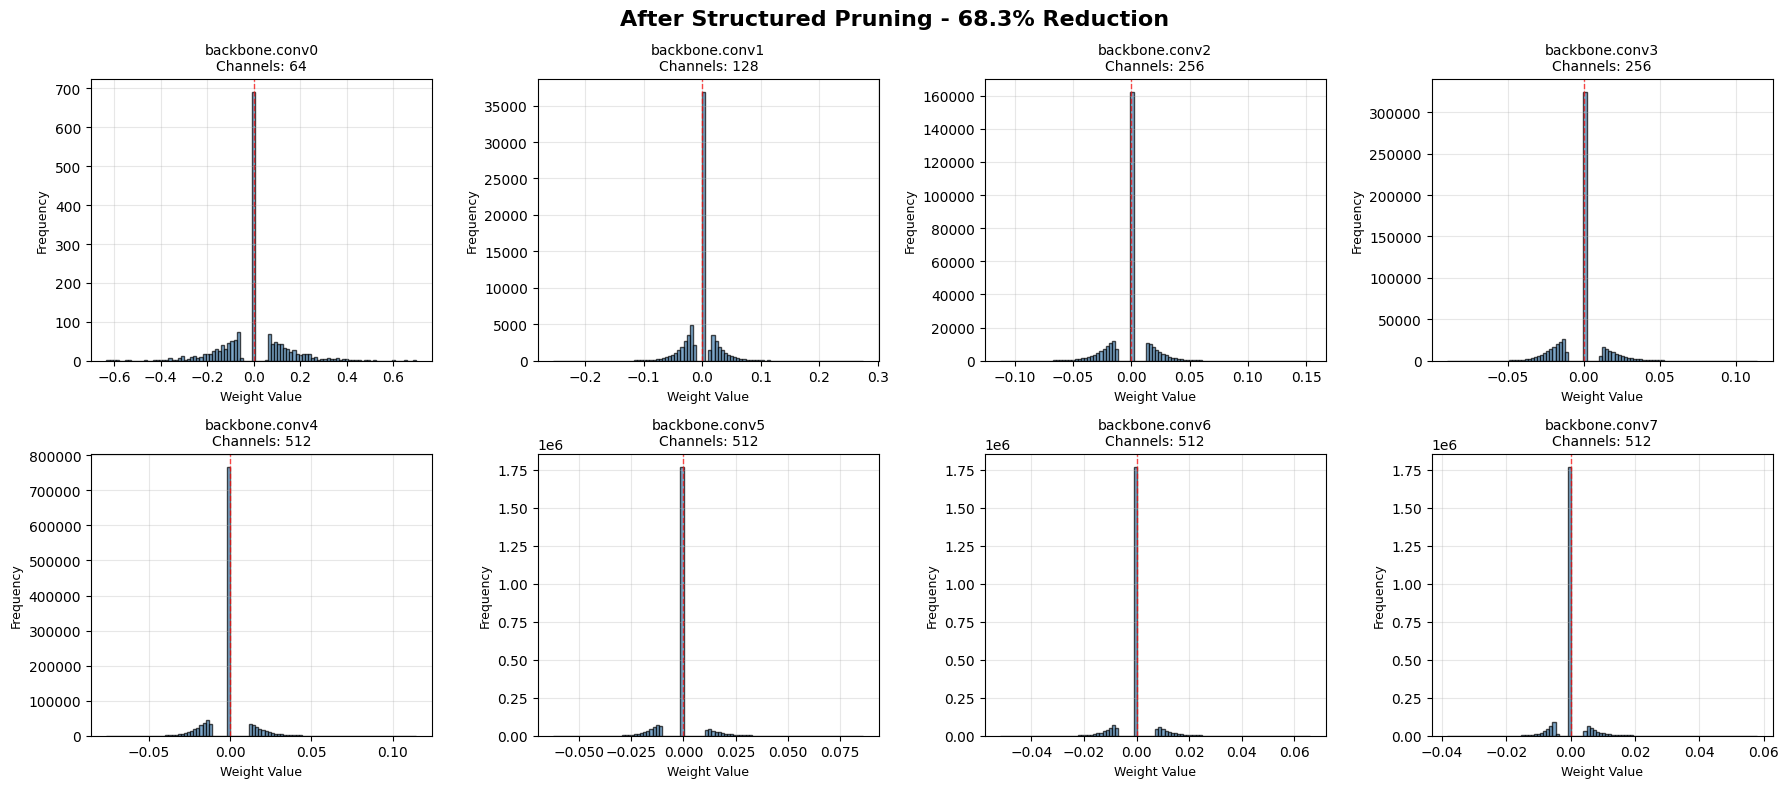


 Pruned model saved as 'vgg11_pruned_structured.pth'


In [61]:
# Applying Pruning

print("APPLYING STRUCTURED PRUNING")

pruned_model2 = copy.deepcopy(model)
pruned_model2 = apply_structured_pruning(pruned_model2, prune_config2)

# Calculate actual statistics
pruned_params2 = count_parameters(pruned_model2)
pruned_size2 = calculate_model_size(pruned_model2)
actual_retention = 100 * pruned_params2 / base_params
actual_reduction = 100 - actual_retention

print(f"\n ACTUAL RESULTS:")
print(f"  Parameters: {base_params:,} → {pruned_params2:,}")
print(f"  Retention: {actual_retention:.1f}%")
print(f"  Reduction: {actual_reduction:.1f}%")
print(f"  Size: {base_size:.2f} MB → {pruned_size2[2]:.2f} MB")

# Evaluate pruned model
print("\nEvaluating pruned model...")
pruned_accuracy2 = evaluate_model(pruned_model2, testloader)
accuracy_drop = base_accuracy - pruned_accuracy2

print(f"\n Base Accuracy: {base_accuracy:.2f}%")
print(f" Pruned Accuracy: {pruned_accuracy2:.2f}%")
print(f" Accuracy Drop: {accuracy_drop:.2f}%")

# Visualize after pruning
print("\nPlotting weight distribution after pruning...")
plot_weight_distribution_structured(pruned_model,
                                   f"After Structured Pruning - {actual_reduction:.1f}% Reduction",
                                   "weights_after_structured.png")
# Save pruned model
torch.save({
    'model_state': pruned_model.state_dict(),
    'prune_config': prune_config2,
    'base_accuracy': base_accuracy,
    'pruned_accuracy': pruned_accuracy2,
    'base_params': base_params,
    'pruned_params': pruned_params2,
}, 'vgg11_pruned_structured.pth')

print("\n Pruned model saved as 'vgg11_pruned_structured.pth'")

In [62]:
# #final comparison

print("FINAL SUMMARY - STRUCTURED PRUNING")

print(f"{'Metric':<30} {'Base Model':<20} {'Pruned Model':<20}")

print(f"{'Accuracy (%)':<30} {base_accuracy:<20.2f} {pruned_accuracy2:<20.2f}")
print(f"{'Parameters':<30} {base_params:<20,} {pruned_params2:<20,}")
print(f"{'Model Size (MB)':<30} {base_size:<20.2f} {pruned_size2[2]:<20.2f}")
print(f"{'Accuracy Drop (%)':<30} {'-':<20} {accuracy_drop:<20.2f}")
print(f"{'Size Reduction (%)':<30} {'-':<20} {actual_reduction:<20.1f}")

print("\n Structured pruning complete!")
print(f" Achieved {actual_reduction:.1f}% size reduction with {accuracy_drop:.2f}% accuracy drop")

FINAL SUMMARY - STRUCTURED PRUNING
Metric                         Base Model           Pruned Model        
Accuracy (%)                   92.95                29.99               
Parameters                     9,228,362            2,929,984           
Model Size (MB)                35.22                11.19               
Accuracy Drop (%)              -                    62.96               
Size Reduction (%)             -                    68.3                

 Structured pruning complete!
 Achieved 68.3% size reduction with 62.96% accuracy drop


COMPARSION OF BASE MODEL, UNSTRUCTUED PRUNED MODEL AND STRUCTURED PRUNE MODEL

In [44]:
# Install pytorch-grad-cam if not already installed
try:
    from pytorch_grad_cam import GradCAM
    from pytorch_grad_cam.utils.image import show_cam_on_image
    from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
except ImportError:
    print("Installing pytorch-grad-cam...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'grad-cam'])
    from pytorch_grad_cam import GradCAM
    from pytorch_grad_cam.utils.image import show_cam_on_image
    from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [65]:
import time
# SETUP
# Models already loaded from previous cells:
# - model (base model)
# - pruned_model (unstructured pruned model)
# - pruned_model2 (structured pruned model from structured pruning)

# Verify models exist
try:
    _ = model
    _ = pruned_model
    _ = pruned_model2
    print(" All three models found in memory")
except NameError as e:
    print(f"✗ Error: {e}")
    print("Please ensure you have run:")
    print("  1. Unstructured pruning code (creates 'pruned_model')")
    print("  2. Structured pruning code (creates 'pruned_model2')")
    raise

#utility function

def measure_inference_time_batch(model, testloader, num_iterations=100):
    """Measure average inference time per batch"""
    model.eval()
    times = []

    with torch.no_grad():
        # Warmup
        for i, (inputs, _) in enumerate(testloader):
            if i >= 10:
                break
            inputs = inputs.to(device)
            _ = model(inputs)

        # Measure
        for i, (inputs, _) in enumerate(testloader):
            if i >= num_iterations:
                break
            inputs = inputs.to(device)

            if torch.cuda.is_available():
                torch.cuda.synchronize()
            start = time.time()
            _ = model(inputs)
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            end = time.time()

            times.append(end - start)

    return np.mean(times) * 1000  # ms

 All three models found in memory


PART (A): GRAD-CAM VISUALIZATION

Generating Grad-CAM visualizations...
Selecting 6 diverse test images from different classes...

 Saved gradcam_comparison.png


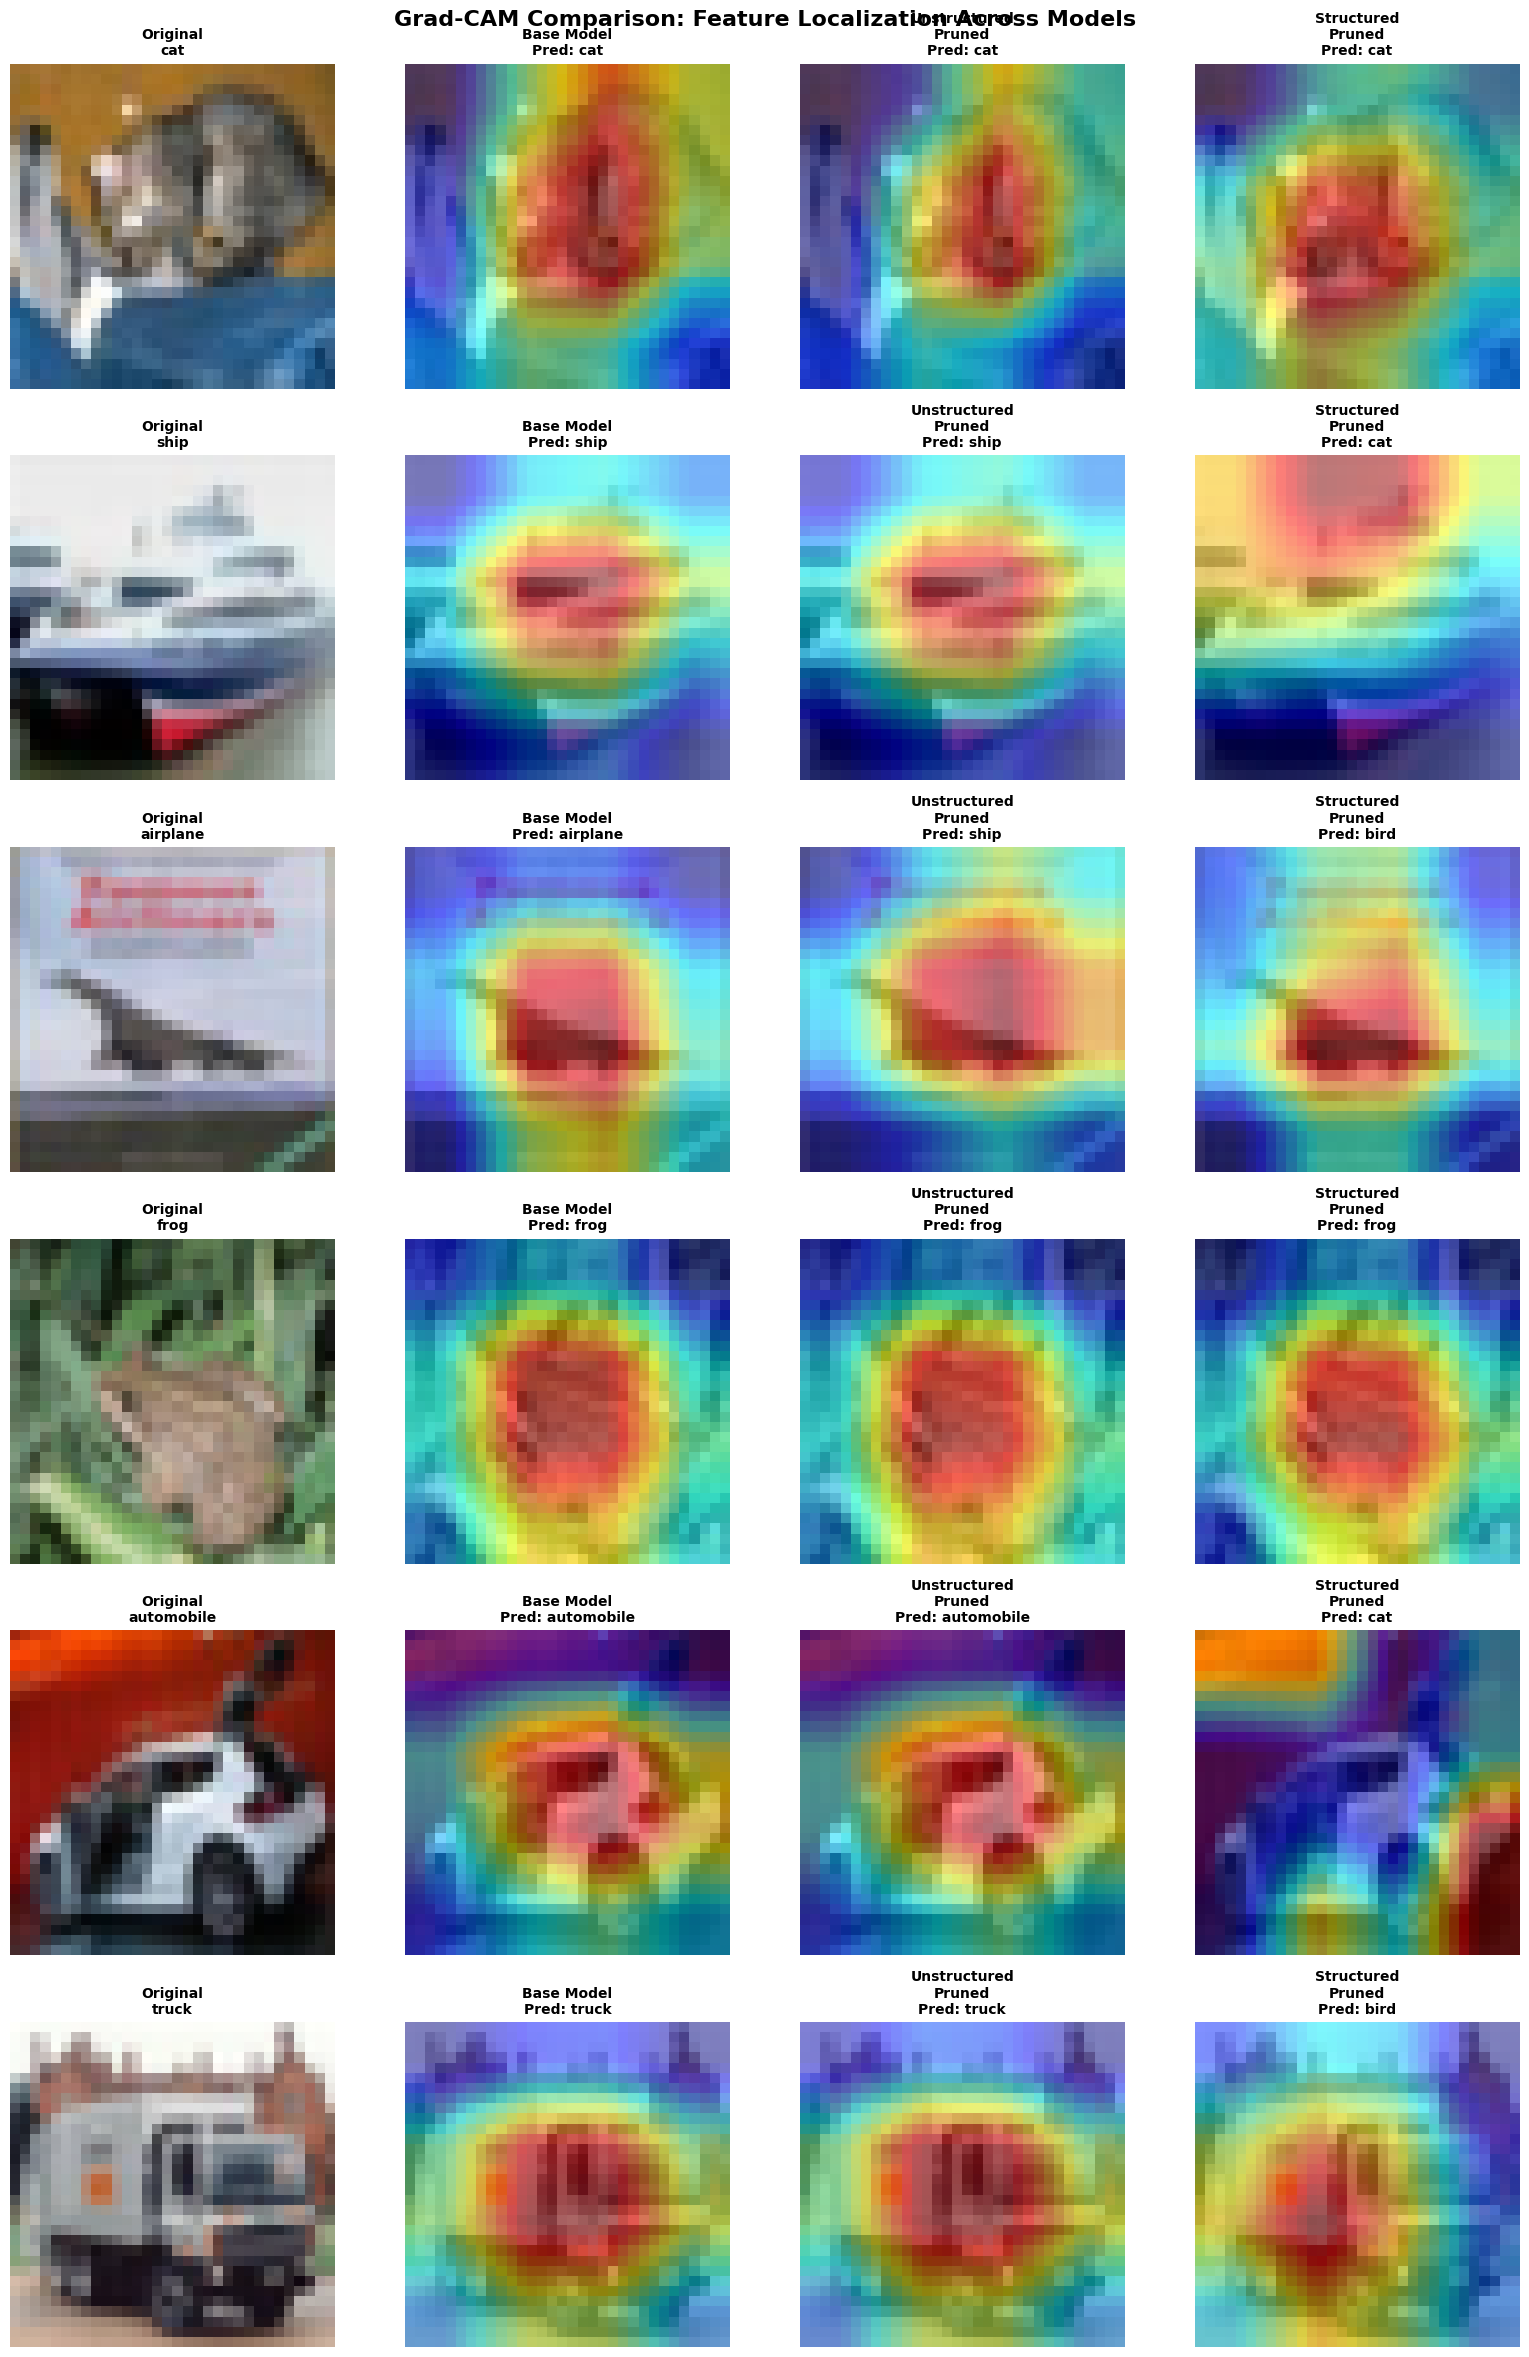

In [66]:
# GRAD-CAM ANALYSIS

print("PART (A): GRAD-CAM VISUALIZATION")

# print("""
# GRAD-CAM (Gradient-weighted Class Activation Mapping):
# - Visualizes which image regions the model focuses on
# - Uses gradients flowing to last conv layer
# - Red = high importance, Blue = low importance

# ANALYSIS GOALS:
# 1. Does pruning change what the model looks at?
# 2. Are important features still detected after pruning?
# 3. How do unstructured vs structured differ in attention?
# """)

def get_last_conv_layer(model):
    """Get the last convolutional layer for Grad-CAM"""
    last_conv = None
    for module in model.modules():
        if isinstance(module, nn.Conv2d):
            last_conv = module
    return last_conv

def generate_gradcam_comparison(models, model_names, test_images, test_labels, num_samples=6):
    """Generate Grad-CAM visualizations for all models"""

    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

    fig, axes = plt.subplots(num_samples, len(models) + 1, figsize=(4*(len(models)+1), 4*num_samples))

    for sample_idx in range(num_samples):
        img = test_images[sample_idx]
        label = test_labels[sample_idx]

        # Original image
        ax = axes[sample_idx, 0] if num_samples > 1 else axes[0]
        img_display = img.permute(1, 2, 0).numpy()
        ax.imshow(img_display)
        ax.set_title(f'Original\n{classes[label]}', fontsize=10, fontweight='bold')
        ax.axis('off')

        # Grad-CAM for each model
        input_tensor = img.unsqueeze(0).to(device)

        for model_idx, (model_curr, name) in enumerate(zip(models, model_names)):
            ax = axes[sample_idx, model_idx + 1] if num_samples > 1 else axes[model_idx + 1]

            try:
                # Get last conv layer
                target_layer = get_last_conv_layer(model_curr)

                if target_layer is None:
                    ax.text(0.5, 0.5, 'No conv layer', ha='center', va='center')
                    ax.axis('off')
                    continue

                # Create Grad-CAM
                cam = GradCAM(model=model_curr, target_layers=[target_layer])

                # Get prediction
                model_curr.eval()
                with torch.no_grad():
                    output = model_curr(input_tensor)
                    pred_class = output.argmax(dim=1).item()

                # Generate CAM for predicted class
                targets = [ClassifierOutputTarget(pred_class)]
                grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
                grayscale_cam = grayscale_cam[0, :]

                # Overlay on image
                visualization = show_cam_on_image(img_display, grayscale_cam, use_rgb=True)

                ax.imshow(visualization)
                ax.set_title(f'{name}\nPred: {classes[pred_class]}', fontsize=10, fontweight='bold')
                ax.axis('off')

            except Exception as e:
                ax.text(0.5, 0.5, f'Error:\n{str(e)[:30]}', ha='center', va='center', fontsize=8)
                ax.axis('off')

    plt.suptitle('Grad-CAM Comparison: Feature Localization Across Models',
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('gradcam_comparison.png', dpi=150, bbox_inches='tight')
    print("\n Saved gradcam_comparison.png")
    plt.show()

# Select diverse test images
print("\nGenerating Grad-CAM visualizations...")
print("Selecting 6 diverse test images from different classes...")

# Get one image from each of 6 different classes
selected_images = []
selected_labels = []
classes_selected = set()

for img, label in testset:
    if label not in classes_selected:
        selected_images.append(img)
        selected_labels.append(label)
        classes_selected.add(label)
    if len(selected_images) >= 6:
        break

models_list = [model, pruned_model, pruned_model2]
model_names_list = ['Base Model', 'Unstructured\nPruned', 'Structured\nPruned']

generate_gradcam_comparison(models_list, model_names_list, selected_images, selected_labels)

PART (C): INFERENCE TIME & STORAGE COMPARISON

Measuring metrics for all three models...

1. Evaluating accuracies...


   Base: 92.95%
   Unstructured: 89.51%
   Structured: 29.99%

2. Calculating model sizes...
   Base: 9,228,362 params, 35.22 MB
   Unstructured: 9,228,362 params, 70.41 MB
   Structured: 2,929,984 params, 11.19 MB

3. Calculating sparsity...
   Base: 0.00%
   Unstructured: 71.55%
   Structured: 0.00%

4. Measuring inference times (averaged over 100 iterations)...


   Base: 15.87 ms
   Unstructured: 16.43 ms (0.97x speedup)
   Structured: 10.77 ms (1.47x speedup)

COMPREHENSIVE COMPARISON TABLE
Metric                         Base Model           Unstructured         Structured          
------------------------------------------------------------------------------------------
Accuracy (%)                   92.95                89.51                29.99               
Accuracy Drop (%)              -                    3.44                 62.96               
Parameters                     9,228,362            9,228,362            2,929,984           
Sparsity (%)                   0.0                  71.6                 0.0                 
Model Size (MB)                35.22                70.41                11.19               
Size Reduction (%)             -                    -99.9                68.2                
Inference Time (ms)            15.87                16.43                10.77               
Speedup                  

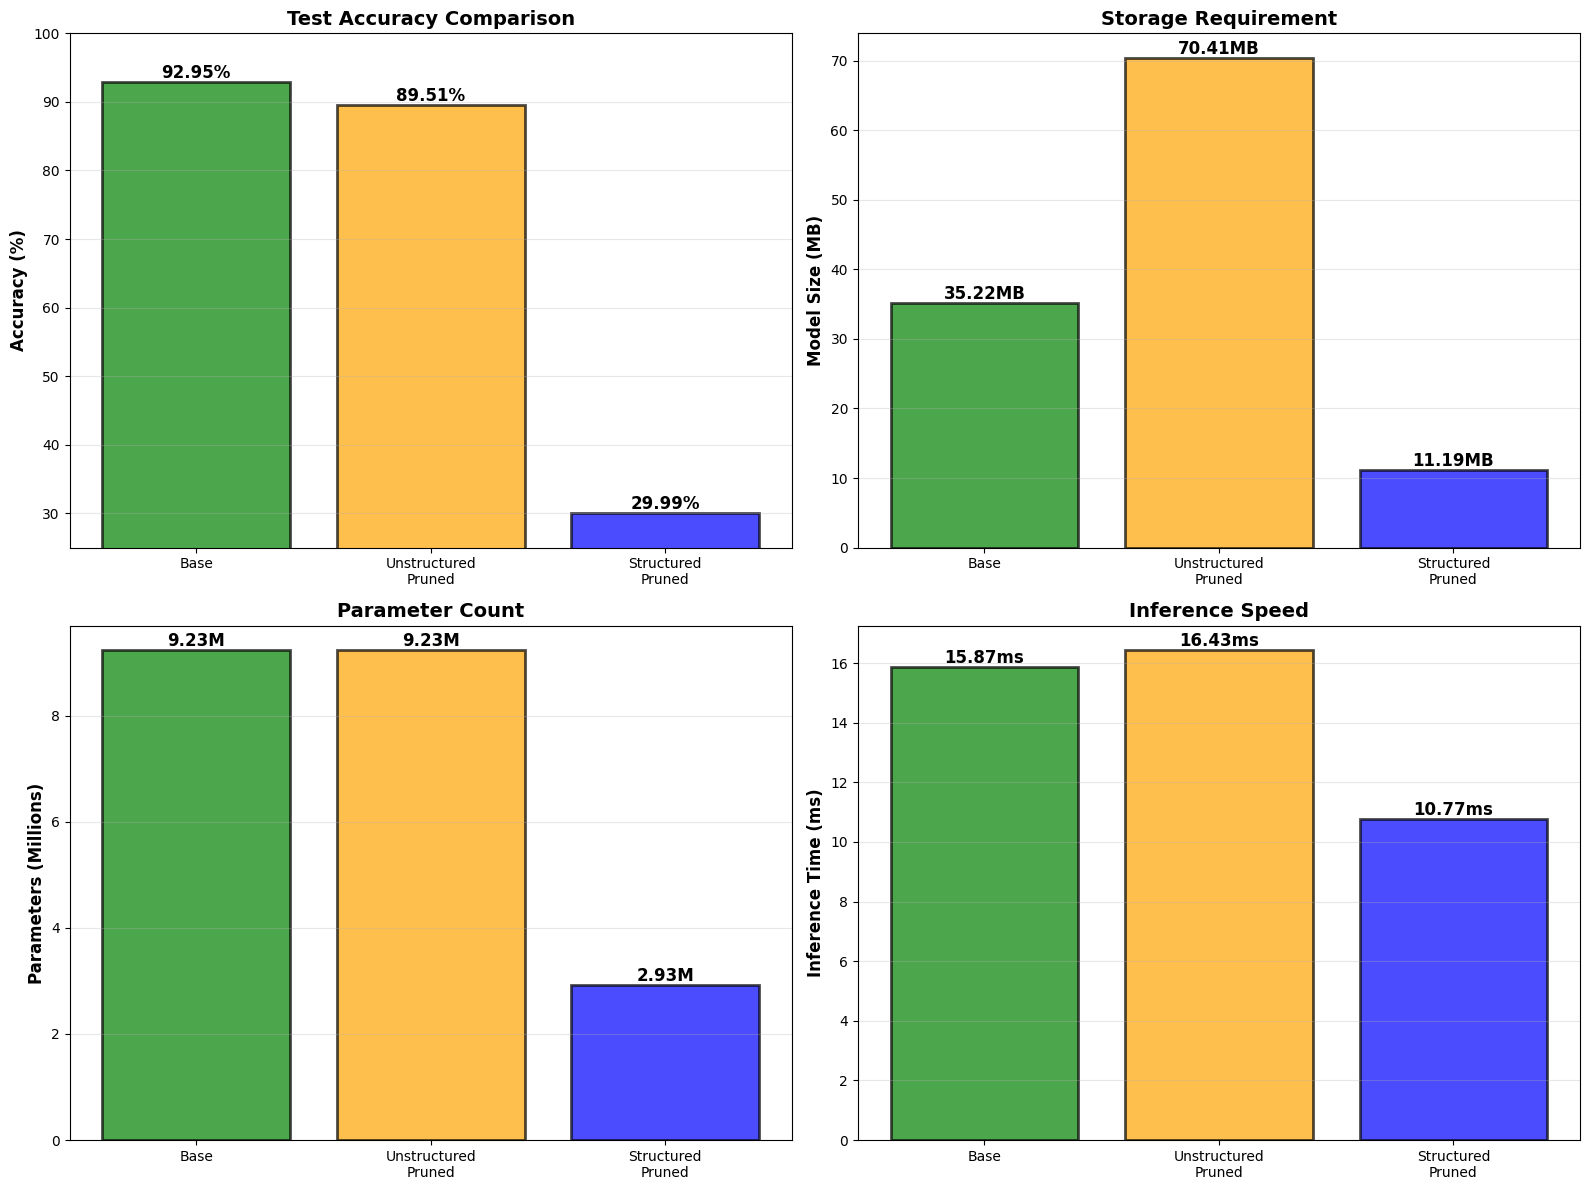

In [67]:
# INFERENCE TIME & STORAGE

print("PART (C): INFERENCE TIME & STORAGE COMPARISON")

print("\nMeasuring metrics for all three models...\n")

# Evaluate all models
print("1. Evaluating accuracies...")
base_acc = evaluate_model(model, testloader)
unstruct_acc = evaluate_model(pruned_model, testloader)
struct_acc = evaluate_model(pruned_model2, testloader)

print(f"   Base: {base_acc:.2f}%")
print(f"   Unstructured: {unstruct_acc:.2f}%")
print(f"   Structured: {struct_acc:.2f}%")

# Calculate sizes
print("\n2. Calculating model sizes...")
base_params, _, base_size = calculate_model_size(model)
unstruct_params, _, unstruct_size = calculate_model_size(pruned_model)
struct_params, _, struct_size = calculate_model_size(pruned_model2)

print(f"   Base: {base_params:,} params, {base_size:.2f} MB")
print(f"   Unstructured: {unstruct_params:,} params, {unstruct_size:.2f} MB")
print(f"   Structured: {struct_params:,} params, {struct_size:.2f} MB")

# Calculate sparsity
print("\n3. Calculating sparsity...")
base_sparsity = calculate_sparsity(model)
unstruct_sparsity = calculate_sparsity(pruned_model)
struct_sparsity = calculate_sparsity(pruned_model2)

print(f"   Base: {base_sparsity:.2f}%")
print(f"   Unstructured: {unstruct_sparsity:.2f}%")
print(f"   Structured: {struct_sparsity:.2f}%")

# Measure inference times
print("\n4. Measuring inference times (averaged over 100 iterations)...")
base_time = measure_inference_time_batch(model, testloader)
unstruct_time = measure_inference_time_batch(pruned_model, testloader)
struct_time = measure_inference_time_batch(pruned_model2, testloader)

print(f"   Base: {base_time:.2f} ms")
print(f"   Unstructured: {unstruct_time:.2f} ms ({base_time/unstruct_time:.2f}x speedup)")
print(f"   Structured: {struct_time:.2f} ms ({base_time/struct_time:.2f}x speedup)")

# Create comparison table
print("\n" + "="*90)
print("COMPREHENSIVE COMPARISON TABLE")
print("="*90)
print(f"{'Metric':<30} {'Base Model':<20} {'Unstructured':<20} {'Structured':<20}")
print("-" * 90)
print(f"{'Accuracy (%)':<30} {base_acc:<20.2f} {unstruct_acc:<20.2f} {struct_acc:<20.2f}")
print(f"{'Accuracy Drop (%)':<30} {'-':<20} {base_acc - unstruct_acc:<20.2f} {base_acc - struct_acc:<20.2f}")
print(f"{'Parameters':<30} {base_params:<20,} {unstruct_params:<20,} {struct_params:<20,}")
print(f"{'Sparsity (%)':<30} {base_sparsity:<20.1f} {unstruct_sparsity:<20.1f} {struct_sparsity:<20.1f}")
print(f"{'Model Size (MB)':<30} {base_size:<20.2f} {unstruct_size:<20.2f} {struct_size:<20.2f}")
print(f"{'Size Reduction (%)':<30} {'-':<20} {100*(1-unstruct_size/base_size):<20.1f} {100*(1-struct_size/base_size):<20.1f}")
print(f"{'Inference Time (ms)':<30} {base_time:<20.2f} {unstruct_time:<20.2f} {struct_time:<20.2f}")
print(f"{'Speedup':<30} {'-':<20} {base_time/unstruct_time:<20.2f} {base_time/struct_time:<20.2f}")
print("="*90)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

models_labels = ['Base', 'Unstructured\nPruned', 'Structured\nPruned']
colors = ['green', 'orange', 'blue']

# Plot 1: Accuracy
ax1 = axes[0, 0]
accuracies = [base_acc, unstruct_acc, struct_acc]
bars = ax1.bar(models_labels, accuracies, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.2f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax1.set_title('Test Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.set_ylim([min(accuracies) - 5, 100])
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: Model Size
ax2 = axes[0, 1]
sizes = [base_size, unstruct_size, struct_size]
bars = ax2.bar(models_labels, sizes, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
for bar, size in zip(bars, sizes):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{size:.2f}MB', ha='center', va='bottom', fontsize=12, fontweight='bold')
ax2.set_ylabel('Model Size (MB)', fontsize=12, fontweight='bold')
ax2.set_title('Storage Requirement', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Parameters
ax3 = axes[1, 0]
params = [base_params/1e6, unstruct_params/1e6, struct_params/1e6]
bars = ax3.bar(models_labels, params, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
for bar, p in zip(bars, params):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{p:.2f}M', ha='center', va='bottom', fontsize=12, fontweight='bold')
ax3.set_ylabel('Parameters (Millions)', fontsize=12, fontweight='bold')
ax3.set_title('Parameter Count', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Inference Time
ax4 = axes[1, 1]
times = [base_time, unstruct_time, struct_time]
bars = ax4.bar(models_labels, times, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
for bar, t in zip(bars, times):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{t:.2f}ms', ha='center', va='bottom', fontsize=12, fontweight='bold')
ax4.set_ylabel('Inference Time (ms)', fontsize=12, fontweight='bold')
ax4.set_title('Inference Speed', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('complete_comparison.png', dpi=150, bbox_inches='tight')
print("\n Saved complete_comparison.png")
plt.show()

PART (D): ACCURACY VS TARGET SPARSITY

Testing different sparsity levels to show accuracy-efficiency tradeoff.
Using UNSTRUCTURED pruning with 5 different sparsity targets...


Testing sparsity levels:

  Testing 0% sparsity...


    Accuracy: 92.95%
    Actual sparsity: 0.0%
    Inference time: 16.22 ms

  Testing 30% sparsity...


    Accuracy: 92.92%
    Actual sparsity: 30.0%
    Inference time: 15.96 ms

  Testing 50% sparsity...


    Accuracy: 92.67%
    Actual sparsity: 50.0%
    Inference time: 15.89 ms

  Testing 70% sparsity...


    Accuracy: 89.97%
    Actual sparsity: 70.0%
    Inference time: 18.24 ms

  Testing 85% sparsity...


    Accuracy: 43.16%
    Actual sparsity: 85.0%
    Inference time: 15.93 ms

 Saved accuracy_vs_sparsity.png


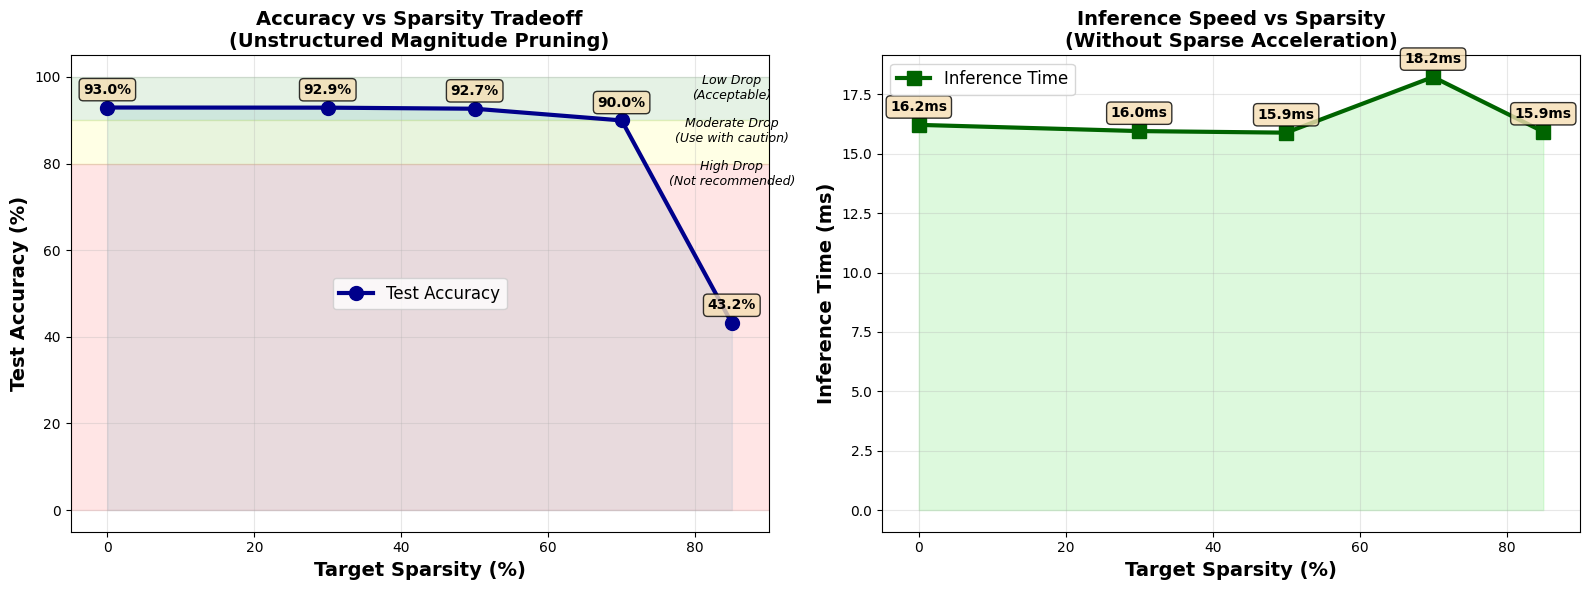


ACCURACY VS SPARSITY SUMMARY
Sparsity (%)         Accuracy (%)         Accuracy Drop (%)         Inference (ms)      
--------------------------------------------------------------------------------
0                    92.95                0.00                      16.22               
30                   92.92                0.03                      15.96               
50                   92.67                0.28                      15.89               
70                   89.97                2.98                      18.24               
85                   43.16                49.79                     15.93               


In [68]:
# ACCURACY VS SPARSITY ====================

print("PART (D): ACCURACY VS TARGET SPARSITY")

print("""
Testing different sparsity levels to show accuracy-efficiency tradeoff.
Using UNSTRUCTURED pruning with 5 different sparsity targets...
""")

# unstructured pruning function
def magnitude_prune_model_uniform(base_model, target_sparsity):
    """Apply uniform magnitude-based unstructured pruning"""
    pruned = copy.deepcopy(base_model)

    # Collect all weights
    all_weights = []
    for module in pruned.modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            all_weights.append(module.weight.data.abs().flatten())

    # Concatenate all weights
    all_weights = torch.cat(all_weights)

    # Calculate threshold
    threshold = torch.quantile(all_weights, target_sparsity)

    # Apply pruning
    for module in pruned.modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            mask = (module.weight.data.abs() > threshold).float()
            module.weight.data *= mask

    return pruned

# Test 5 different sparsity levels
sparsity_levels = [0.0, 0.3, 0.5, 0.7, 0.85]
accuracies = []
inference_times = []
param_counts = []

print("\nTesting sparsity levels:")
for sparsity in sparsity_levels:
    print(f"\n  Testing {sparsity*100:.0f}% sparsity...")

    if sparsity == 0.0:
        # Base model
        test_model = model
    else:
        # Prune model
        test_model = magnitude_prune_model_uniform(model, sparsity)

    # Evaluate
    acc = evaluate_model(test_model, testloader)
    time_ms = measure_inference_time_batch(test_model, testloader, num_iterations=50)
    params, _, _ = calculate_model_size(test_model) # Corrected: unpack all three values
    actual_sparsity = calculate_sparsity(test_model)

    accuracies.append(acc)
    inference_times.append(time_ms)
    param_counts.append(params)

    print(f"    Accuracy: {acc:.2f}%")
    print(f"    Actual sparsity: {actual_sparsity:.1f}%")
    print(f"    Inference time: {time_ms:.2f} ms")

    if sparsity > 0:
        del test_model
        torch.cuda.empty_cache()

# Create accuracy vs sparsity plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Accuracy vs Sparsity
ax1 = axes[0]
sparsity_pcts = [s*100 for s in sparsity_levels]
ax1.plot(sparsity_pcts, accuracies, 'o-', linewidth=3, markersize=10,
         color='darkblue', label='Test Accuracy')
ax1.fill_between(sparsity_pcts, accuracies, alpha=0.3, color='lightblue')

# Mark each point
for sp, acc in zip(sparsity_pcts, accuracies):
    ax1.annotate(f'{acc:.1f}%', xy=(sp, acc), xytext=(0, 10),
                textcoords='offset points', ha='center', fontsize=10,
                fontweight='bold', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

ax1.set_xlabel('Target Sparsity (%)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Test Accuracy (%)', fontsize=14, fontweight='bold')
ax1.set_title('Accuracy vs Sparsity Tradeoff\n(Unstructured Magnitude Pruning)',
             fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xlim([-5, 90])
ax1.legend(fontsize=12)

# Add interpretation zones
ax1.axhspan(90, 100, alpha=0.1, color='green')
ax1.axhspan(80, 90, alpha=0.1, color='yellow')
ax1.axhspan(0, 80, alpha=0.1, color='red')
ax1.text(85, 95, 'Low Drop\n(Acceptable)', fontsize=9, ha='center', style='italic')
ax1.text(85, 85, 'Moderate Drop\n(Use with caution)', fontsize=9, ha='center', style='italic')
ax1.text(85, 75, 'High Drop\n(Not recommended)', fontsize=9, ha='center', style='italic')

# Plot 2: Inference Time vs Sparsity
ax2 = axes[1]
ax2.plot(sparsity_pcts, inference_times, 's-', linewidth=3, markersize=10,
         color='darkgreen', label='Inference Time')
ax2.fill_between(sparsity_pcts, inference_times, alpha=0.3, color='lightgreen')

for sp, t in zip(sparsity_pcts, inference_times):
    ax2.annotate(f'{t:.1f}ms', xy=(sp, t), xytext=(0, 10),
                textcoords='offset points', ha='center', fontsize=10,
                fontweight='bold', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

ax2.set_xlabel('Target Sparsity (%)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Inference Time (ms)', fontsize=14, fontweight='bold')
ax2.set_title('Inference Speed vs Sparsity\n(Without Sparse Acceleration)',
             fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xlim([-5, 90])
ax2.legend(fontsize=12)

plt.tight_layout()
plt.savefig('accuracy_vs_sparsity.png', dpi=150, bbox_inches='tight')
print("\n Saved accuracy_vs_sparsity.png")
plt.show()

# Summary table
print("\n" + "="*80)
print("ACCURACY VS SPARSITY SUMMARY")
print("="*80)
print(f"{'Sparsity (%)':<20} {'Accuracy (%)':<20} {'Accuracy Drop (%)':<25} {'Inference (ms)':<20}")
print("-" * 80)
for sp, acc, time_val in zip(sparsity_pcts, accuracies, inference_times):
    drop = base_acc - acc
    print(f"{sp:<20.0f} {acc:<20.2f} {drop:<25.2f} {time_val:<20.2f}")
print("="*80)